In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from prophet import Prophet

import sys
sys.path.append('../')
from utils import helper_forecast

**SARIMA IMPLEMENTATION**

In [5]:
#reading the data
df = pd.read_csv('/Users/ridhipurohit/Documents/GitHub/energy_project_CSEP/energy_modeling/data/clean_data/combined_data_2013_20.csv')

#test and train split
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day


In [3]:
# generate date range from the minimum to maximum date in the DataFrame
min_date = df['date'].min()
max_date = df['date'].max()
date_range = pd.date_range(start=min_date, end=max_date)

# find missing dates 
missing_dates = date_range[~date_range.isin(df['date'])]

if not missing_dates.empty:
    print(f"Missing dates: {missing_dates}")
else:
    print("No missing dates found.")

Missing dates: DatetimeIndex(['2013-05-30', '2013-06-03', '2013-06-28', '2013-07-27',
               '2013-08-13', '2013-08-28', '2013-08-29', '2013-09-14',
               '2013-09-20', '2013-09-23', '2013-10-15', '2015-05-02',
               '2015-07-03', '2015-07-12', '2015-07-13', '2016-03-07',
               '2016-03-23', '2016-03-25', '2020-03-28'],
              dtype='datetime64[ns]', freq=None)


In [4]:
# testing for stationarity in data

differenced_data = helper_forecast.test_stationarity(df['Total_peak_demand'])


Data is not stationary so differencing applied


In [5]:
# testing for stationarity in data if differencing applied

test_diff_data = helper_forecast.test_stationarity(differenced_data)

Data is stationary, nothing returned


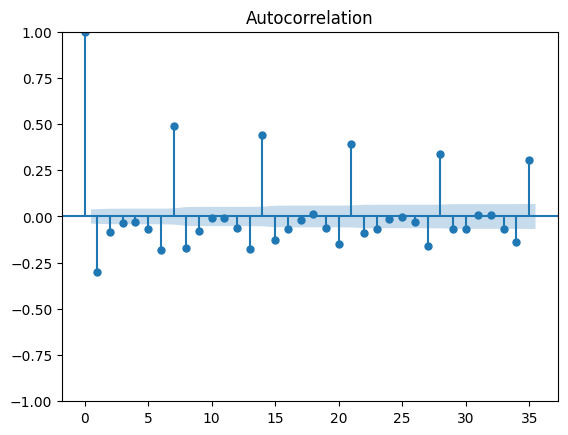

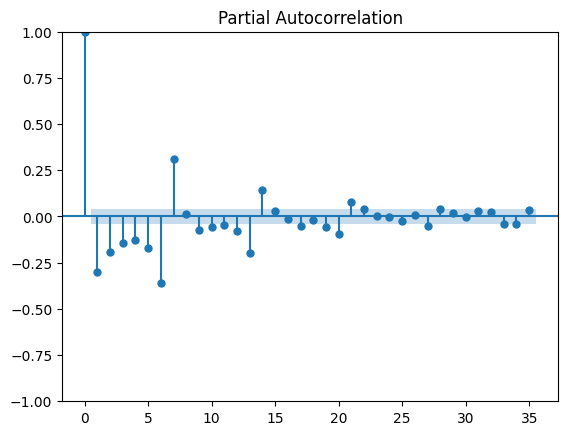

In [6]:
# plot ACF and PCF to determine model parameters for SARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# autocorrelation plot
plot_acf(differenced_data)  

# partial autocorrelation plot
plot_pacf(differenced_data)  
plt.show()

In [7]:
# create training, validation and test data sets

train = df[df['year'].between(2013, 2017)]
val = df[df['year'] == 2018]
test = df[df['year'] == 2019]

In [8]:
# testing for basic SARIMA model parameters
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

model = sm.tsa.statespace.SARIMAX(train['Total_peak_demand'], order=order, seasonal_order=seasonal_order)
results = model.fit()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83940D+00    |proj g|=  7.15064D-02

At iterate    5    f=  9.78315D+00    |proj g|=  2.26092D-02

At iterate   10    f=  9.77792D+00    |proj g|=  5.09825D-04

At iterate   15    f=  9.77788D+00    |proj g|=  1.01232D-04

At iterate   20    f=  9.77766D+00    |proj g|=  4.39751D-03

At iterate   25    f=  9.70942D+00    |proj g|=  6.34754D-02

At iterate   30    f=  9.69809D+00    |proj g|=  6.72963D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

In [9]:
# finding RMSE for basic model parameters on validation data

val_predictions = results.predict(start=len(train), end=len(train) + len(val) - 1, dynamic=False)
val_rmse = helper_forecast.rmse(val['Total_peak_demand'], val_predictions)

print(f"Validation Data RMSE for SARMIA: {val_rmse}")

Validation Data RMSE for SARMIA: 9186.508771891169


In [10]:
# finding RMSE for basic model parameters on test data

test_predictions = results.predict(start=len(train) + len(val), end=len(train) + len(val) + len(test) - 1, dynamic=False)
test_rmse = helper_forecast.rmse(test['Total_peak_demand'], test_predictions)

print(f"Test Data RMSE for SARMIA: {test_rmse}")

Test Data RMSE for SARMIA: 31961.42543373612


In [11]:
# shape (rows and columns) of each dataset

print("Train data shape:", train.shape)
print("Validation data shape:", val.shape)
print("Test data shape:", test.shape)

Train data shape: (1756, 16)
Validation data shape: (368, 16)
Test data shape: (366, 16)


In [12]:
# grid search to find the best (top 3) SARIMA model parameters

top_3_results_rmse, top_3_results_mape = helper_forecast.find_best_sarima(train, val)

# Print the top 3 results by RMSE
for i, (rmse, order, seasonal_order) in enumerate(top_3_results_rmse, start=1):
    print(f"Top {i} - RMSE: {rmse}, Order: {order}, Seasonal Order: {seasonal_order}")

# Print the top 3 results by MAPE
for i, (mape, order, seasonal_order) in enumerate(top_3_results_mape, start=1):
    print(f"Top {i} - MAPE: {mape}, Order: {order}, Seasonal Order: {seasonal_order}")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32185D+01    |proj g|=  0.00000D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   0.000D+00   1.322D+01
  F =   13.218537264517584     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.31061D+01    |proj g|=  6.51471D-01

At iterate    5    f=  1.28659D+01    |proj g|=  4.34720D-03

At iterate   10    f=  1.28646D+01    |proj g|=  5.45840D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     10     11      1     0     0   5.458D-06   1.286D+01
  F =   12.864618644395128     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03719D+01    |proj g|=  3.56011D-01


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      3      7      1     0     0   2.081D-05   1.008D+01
  F =   10.084526448711852     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.28655D+02    |proj g|=  4.34532D+02

At iterate    5    f=  1.28015D+01    |proj g|=  4.20904D+00

At iterate   10    f=  1.04138D+01    |proj g|=  1.78765D-01

At iterate   15    f=  1.02158D+01    |proj g|=  7.93945D-03

At iterate   20    f=  1.01984D+01    |proj g|=  2.82947D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     24     25      1     0     0   1.372D-06   1.020D+01
  F =   10.197955587362371     

CONVERG

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.12163D+03    |proj g|=  1.80913D+04

At iterate    5    f=  4.20090D+01    |proj g|=  7.82441D+01

At iterate   10    f=  1.24029D+01    |proj g|=  3.26570D+00

At iterate   15    f=  1.04146D+01    |proj g|=  1.48258D-01

At iterate   20    f=  1.01007D+01    |proj g|=  2.54744D-02

At iterate   25    f=  1.00502D+01    |proj g|=  9.32630D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     39      1     0     0   

 This problem is unconstrained.



At iterate    5    f=  1.00869D+01    |proj g|=  2.40650D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   2.407D-05   1.009D+01
  F =   10.086949609956383     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04319D+01    |proj g|=  1.06623D+00


 This problem is unconstrained.



At iterate    5    f=  1.00883D+01    |proj g|=  3.92784D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     13      1     0     0   3.209D-05   1.009D+01
  F =   10.088247285048650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28941D+01    |proj g|=  7.77972D-02

At iterate    5    f=  1.28501D+01    |proj g|=  1.16692D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     10      1     0     0   5.866D-06   1.285D+01
  F =   12.849473700415084     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28546D+01    |proj g|=  2.28559D-01

At iterate    5    f=  1.27646D+01    |proj g|=  1.86842D-03

At iterate   10    f=  1.27632D+01    |proj g|=  2.99773D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     12      1     0     0   6.925D-06   1.276D+01
  F =   12.763174244893660     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00104D+01    |proj g|=  1.45382D-01


 This problem is unconstrained.



At iterate    5    f=  9.91821D+00    |proj g|=  5.66488D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   2.335D-05   9.918D+00
  F =   9.9181896900004496     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28941D+01    |proj g|=  3.47332D-01

At iterate    5    f=  1.27275D+01    |proj g|=  2.13419D-03

At iterate   10    f=  1.27273D+01    |proj g|=  1.20425D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     14      1     0     0   7.466D-06   1.273D+01
  F =   12.727251584182863     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.86917D+01    |proj g|=  1.18561D+01

At iterate    5    f=  1.27421D+01    |proj g|=  4.82737D-02

At iterate   10    f=  1.27276D+01    |proj g|=  1.68409D-03


 This problem is unconstrained.



At iterate   15    f=  1.27260D+01    |proj g|=  1.02496D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     19      1     0     0   7.470D-06   1.273D+01
  F =   12.725960927098741     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.97291D+00    |proj g|=  3.42380D-01


 This problem is unconstrained.



At iterate    5    f=  9.92254D+00    |proj g|=  1.03402D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7      9      1     0     0   2.172D-05   9.923D+00
  F =   9.9225351175170449     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00380D+01    |proj g|=  4.86155D-01

At iterate    5    f=  9.91780D+00    |proj g|=  4.96299D-03

At iterate   10    f=  9.91719D+00    |proj g|=  4.36243D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   2.374D-05   9.917D+00
  F =   9.9171928376153762     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28274D+01    |proj g|=  1.14007D-01

At iterate    5    f=  1.27648D+01    |proj g|=  8.07305D-04

At iterate   10    f=  1.27645D+01    |proj g|=  8.17017D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     15      1     0     0   6.843D-06   1.276D+01
  F =   12.764542378735879     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28030D+01    |proj g|=  1.40394D-01

At iterate    5    f=  1.27393D+01    |proj g|=  1.14006D-03

At iterate   10    f=  1.27390D+01    |proj g|=  7.26104D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   7.261D-06   1.274D+01
  F =   12.739009107286922     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   3.424D-06   9.951D+00
  F =   9.9512844782732301     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.93086D+00    |proj g|=  2.34852D-01

At iterate    5    f=  9.88189D+00    |proj g|=  2.80113D-02

At iterate   10    f=  9.88116D+00    |proj g|=  2.92420D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     15      1     0     0   2.924D-05   9.881D+00
  F =   9.8811602405291534     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.28274D+01    |proj g|=  2.14051D-01

At iterate    5    f=  1.27265D+01    |proj g|=  8.01950D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8      9      1     0     0   7.466D-06   1.273D+01
  F =   12.726374305206896     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64044D+01    |proj g|=  7.31419D+00


 This problem is unconstrained.



At iterate    5    f=  1.27332D+01    |proj g|=  2.70601D-02

At iterate   10    f=  1.27261D+01    |proj g|=  1.84838D-03

At iterate   15    f=  1.27250D+01    |proj g|=  2.22764D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     19      1     0     0   7.471D-06   1.272D+01
  F =   12.724980939831656     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.91363D+00    |proj g|=  2.29537D-01


 This problem is unconstrained.



At iterate    5    f=  9.89059D+00    |proj g|=  2.56668D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   2.567D-05   9.891D+00
  F =   9.8905925576907823     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.95194D+00    |proj g|=  3.59765D-01


 This problem is unconstrained.



At iterate    5    f=  9.88116D+00    |proj g|=  9.97514D-03

At iterate   10    f=  9.88031D+00    |proj g|=  7.38577D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   2.961D-05   9.880D+00
  F =   9.8803109389870230     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74630D+00    |proj g|=  1.36957D-07

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74552D+00    |proj g|=  5.39412D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   2.251D-06   9.746D+00
  F =   9.7455080740895372     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00523D+01    |proj g|=  1.22746D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   1.227D-06   1.005D+01
  F =   10.052317327783969     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81153D+00    |proj g|=  5.39302D-02


 This problem is unconstrained.



At iterate    5    f=  9.78348D+00    |proj g|=  5.93676D-04

At iterate   10    f=  9.78326D+00    |proj g|=  1.17306D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     13     18      1     0     0   2.277D-06   9.753D+00
  F =   9.7531988099576328     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74583D+00    |proj g|=  2.89910D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74558D+00    |proj g|=  2.70652D-03


 This problem is unconstrained.



At iterate    5    f=  9.74557D+00    |proj g|=  5.19467D-03

At iterate   10    f=  9.74513D+00    |proj g|=  1.52060D-02

At iterate   15    f=  9.74478D+00    |proj g|=  7.29688D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     18      1     0     0   1.734D-06   9.745D+00
  F =   9.7447765530614259     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.92929D+00    |proj g|=  7.09397D-02


 This problem is unconstrained.



At iterate    5    f=  9.92524D+00    |proj g|=  8.33769D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   8.338D-06   9.925D+00
  F =   9.9252355527553782     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86480D+00    |proj g|=  9.80104D-02


 This problem is unconstrained.



At iterate    5    f=  9.77339D+00    |proj g|=  8.94120D-03

At iterate   10    f=  9.76736D+00    |proj g|=  1.11013D-03

At iterate   15    f=  9.76727D+00    |proj g|=  4.73591D-05

At iterate   20    f=  9.76719D+00    |proj g|=  5.33093D-04

At iterate   25    f=  9.74930D+00    |proj g|=  6.43933D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     26     34      1     0     0   3.187D-06   9.749D+00
  F =   9.7492969218893499     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.70587D+00    |proj g|=  5.67023D-02

At iterate    5    f=  9.70327D+00    |proj g|=  1.07633D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   1.076D-05   9.703D+00
  F =   9.7032709042547438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00224D+01    |proj g|=  4.85931D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   3.391D-06   1.002D+01
  F =   10.022362629908690     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.8

 This problem is unconstrained.



At iterate    5    f=  9.79176D+00    |proj g|=  8.12686D-04

At iterate   10    f=  9.79153D+00    |proj g|=  1.58257D-04

At iterate   15    f=  9.71513D+00    |proj g|=  3.13947D-02

At iterate   20    f=  9.71243D+00    |proj g|=  7.22089D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     20     25      1     0     0   7.221D-07   9.712D+00
  F =   9.7124250891506705     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.70607D+00    |proj g|=  4.98309D-02

At iterate    5    f=  9.70366D+00    |proj g|=  3.10095D-03

At iterate   10    f=  9.70271D+00    |proj g|=  2.93918D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     16      1     0     0   1.045D-05   9.703D+00
  F =   9.7027132823275544     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  9.90364D+00    |proj g|=  3.75952D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   3.760D-05   9.904D+00
  F =   9.9036444961678587     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.85433D+00    |proj g|=  7.13540D-02


 This problem is unconstrained.



At iterate    5    f=  9.79271D+00    |proj g|=  7.86492D-03

At iterate   10    f=  9.79060D+00    |proj g|=  1.58706D-04

At iterate   15    f=  9.78948D+00    |proj g|=  5.48910D-03

At iterate   20    f=  9.71032D+00    |proj g|=  8.27835D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     28      1     0     0   1.219D-06   9.710D+00
  F =   9.7101882877068668     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.69433D+00    |proj g|=  4.23298D-02


 This problem is unconstrained.



At iterate    5    f=  9.69045D+00    |proj g|=  5.61320D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     10      1     0     0   2.266D-05   9.690D+00
  F =   9.6904472200056446     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00028D+01    |proj g|=  8.32382D-02

At iterate    5    f=  9.99193D+00    |proj g|=  1.06468D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   1.065D-05   9.992D+00
  F =   9.9919334507066342     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  9.76854D+00    |proj g|=  1.47307D-02

At iterate   10    f=  9.76464D+00    |proj g|=  3.23601D-04

At iterate   15    f=  9.76462D+00    |proj g|=  8.24800D-04

At iterate   20    f=  9.76353D+00    |proj g|=  4.58138D-03

At iterate   25    f=  9.70510D+00    |proj g|=  2.37800D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     34      1     0     0   1.721D-05   9.704D+00
  F =   9.7044632025266910     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



At iterate    5    f=  9.69056D+00    |proj g|=  6.21055D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   2.273D-05   9.691D+00
  F =   9.6905575459900994     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.69450D+00    |proj g|=  4.23797D-02

At iterate    5    f=  9.69068D+00    |proj g|=  1.35172D-03

At iterate   10    f=  9.68982D+00    |proj g|=  9.76421D-03

At iterate   15    f=  9.68954D+00    |proj g|=  2.07697D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   2.213D-05   9.690D+00
  F =   9.6895368535002930     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.89022D+00    |proj g|=  1.02436D-01

At iterate    5    f=  9.87628D+00    |proj g|=  3.11685D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   3.433D-05   9.876D+00
  F =   9.8762764937382261     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  9.76938D+00    |proj g|=  1.16962D-02

At iterate   10    f=  9.76242D+00    |proj g|=  4.31959D-03

At iterate   15    f=  9.76236D+00    |proj g|=  3.06019D-04

At iterate   20    f=  9.76228D+00    |proj g|=  5.30137D-03

At iterate   25    f=  9.70025D+00    |proj g|=  2.01982D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     36      1     0     0   1.381D-06   9.700D+00
  F =   9.6999924225253356     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77070D+00    |proj g|=  1.88055D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      4      1     0     0   8.294D-06   9.752D+00
  F =   9.7520439593303063     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.9

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  9.95033D+00    |proj g|=  7.21982D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      5      7      1     0     0   7.220D-06   9.950D+00
  F =   9.9503290631455954     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86122D+00    |proj g|=  2.82067D-01

At iterate    5    f=  9.80711D+00    |proj g|=  7.70761D-03

At iterate   10    f=  9.80461D+00    |proj g|=  1.07107D-04

At iterate   15    f=  9.80461D+00    |proj g|=  2.27612D-04

At iterate   20    f=  9.80407D+00    |proj g|=  3.74507D-03

At iterate   25    f=  9.78601D+00    |proj g|=  8.98503D-03

At iterate   30    f=  9.78318D+00    |proj g|=  3.24073D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.75371D+00    |proj g|=  5.59439D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      4      1     0     0   6.244D-06   9.752D+00
  F =   9.7521402058888143     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05568D+01    |proj g|=  2.04140D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      5      1     0     0   6.351D-05   9.751D+00
  F =   9.7505771407446300     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86969D+00    |proj g|=  1.31588D-01

At iterate    5    f=  9.85774D+00    |proj g|=  1.90389D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      8      1     0     0   2.765D-05   9.858D+00
  F =   9.8577393162083098     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  9.80885D+00    |proj g|=  3.84755D-02

At iterate   10    f=  9.80472D+00    |proj g|=  3.65762D-03

At iterate   15    f=  9.80461D+00    |proj g|=  2.24903D-04

At iterate   20    f=  9.80449D+00    |proj g|=  1.36237D-03

At iterate   25    f=  9.79621D+00    |proj g|=  1.66364D-02

At iterate   30    f=  9.78339D+00    |proj g|=  4.08296D-03

At iterate   35    f=  9.78318D+00    |proj g|=  4.30276D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     42      1     0     0   7.653D-07   9.783D+00
  F =   9.7831759012749728     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.68678D+00    |proj g|=  8.14187D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   9.756D-06   9.676D+00
  F =   9.6760479929572139     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.7

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.95230D+00    |proj g|=  6.73606D-02

At iterate    5    f=  9.94743D+00    |proj g|=  1.29011D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6      9      1     0     0   6.173D-06   9.947D+00
  F =   9.9474298442417446     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86850D+00    |proj g|=  2.98635D-01


 This problem is unconstrained.



At iterate    5    f=  9.79943D+00    |proj g|=  4.25612D-02

At iterate   10    f=  9.78522D+00    |proj g|=  7.13506D-04

At iterate   15    f=  9.78520D+00    |proj g|=  1.58517D-04

At iterate   20    f=  9.78519D+00    |proj g|=  3.46237D-04

At iterate   25    f=  9.78415D+00    |proj g|=  7.42691D-03

At iterate   30    f=  9.75703D+00    |proj g|=  8.59834D-03

At iterate   35    f=  9.75595D+00    |proj g|=  1.92266D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     41      1     0     0   3.218D-06   9.756D+00
  F =   9.7559494725429552     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.68678D+00    |proj g|=  9.74523D-02

At iterate    5    f=  9.67005D+00    |proj g|=  2.92964D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   1.280D-05   9.670D+00
  F =   9.6700518040379109     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03963D+01    |proj g|=  1.84460D+00


 This problem is unconstrained.



At iterate    5    f=  9.66878D+00    |proj g|=  3.50786D-03

At iterate   10    f=  9.66753D+00    |proj g|=  4.28895D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     15      1     0     0   1.411D-05   9.667D+00
  F =   9.6674641073560146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87380D+00    |proj g|=  1.42839D-01


 This problem is unconstrained.



At iterate    5    f=  9.85497D+00    |proj g|=  3.34775D-02

At iterate   10    f=  9.85366D+00    |proj g|=  5.62302D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   2.911D-05   9.854D+00
  F =   9.8536561302527872     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.88775D+00    |proj g|=  3.15640D-01

At iterate    5    f=  9.81042D+00    |proj g|=  9.02537D-02

At iterate   10    f=  9.78261D+00    |proj g|=  2.73957D-03

At iterate   15    f=  9.78216D+00    |proj g|=  3.64355D-03

At iterate   20    f=  9.78004D+00    |proj g|=  4.61798D-02
  ys=-2.653E-04  -gs= 2.143E-04 BFGS update SKIPPED

At iterate   25    f=  9.77606D+00    |proj g|=  3.36793D-03

At iterate   30    f=  9.77389D+00    |proj g|=  7.14138D-04

At iterate   35    f=  9.77384D+00    |proj g|=  6.65768D-05

At iterate   40    f=  9.77383D+00    |proj g|=  9.86123D-04

At iterate   45    f=  9.77279D+00    |proj g|=  3.74799D-02

At iterate   50    f=  9.73889D+00    |proj g|=  1.78703D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04842D+03    |proj g|=  7.87753D+03

At iterate    5    f=  1.80860D+01    |proj g|=  1.80376D+01

At iterate   10    f=  1.08926D+01    |proj g|=  7.54918D-01

At iterate   15    f=  9.82480D+00    |proj g|=  5.67092D-02

At iterate   20    f=  9.67907D+00    |proj g|=  5.41613D-02

At iterate   25    f=  9.65475D+00    |proj g|=  1.70910D-02

At iterate   30    f=  9.65074D+00    |proj g|=  2.10423D-03

At iterate   35    f=  9.65020D+00    |proj g|=  2.43377D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.36059D+03    |proj g|=  6.09436D+03

At iterate    5    f=  1.55856D+01    |proj g|=  1.14649D+01

At iterate   10    f=  1.06149D+01    |proj g|=  5.88412D-01

At iterate   15    f=  9.77852D+00    |proj g|=  8.85386D-02

At iterate   20    f=  9.66277D+00    |proj g|=  1.82433D-02

At iterate   25    f=  9.64924D+00    |proj g|=  9.10226D-03

At iterate   30    f=  9.64696D+00    |proj g|=  1.00347D-03

At iterate   35    f=  9.64677D+00    |proj g|=  3.07915D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  9.94684D+00    |proj g|=  2.02850D-02

At iterate   10    f=  9.94597D+00    |proj g|=  6.94538D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   6.945D-06   9.946D+00
  F =   9.9459669245322466     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84031D+00    |proj g|=  2.57015D-01


 This problem is unconstrained.



At iterate    5    f=  9.79146D+00    |proj g|=  6.06181D-02

At iterate   10    f=  9.75851D+00    |proj g|=  2.73084D-02

At iterate   15    f=  9.74053D+00    |proj g|=  3.44018D-02

At iterate   20    f=  9.73468D+00    |proj g|=  4.37279D-03

At iterate   25    f=  9.73394D+00    |proj g|=  9.00327D-04
  ys=-1.916E-04  -gs= 5.150E-05 BFGS update SKIPPED
  ys=-7.747E-02  -gs= 3.823E-03 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   30    f=  9.73335D+00    |proj g|=  5.58745D-03

At iterate   35    f=  9.73329D+00    |proj g|=  2.67116D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     74      2     2     0   5.649D-05   9.733D+00
  F =   9.7332918188681283     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.04842D+03    |proj g|=  7.87753D+03

At iterate    5    f=  1.39137D+01    |proj g|=  8.73505D+00

At iterate   10    f=  1.05415D+01    |proj g|=  4.64536D-01

At iterate   15    f=  1.01428D+01    |proj g|=  6.05363D-02

At iterate   20    f=  9.70839D+00    |proj g|=  2.47613D-01

At iterate   25    f=  9.66807D+00    |proj g|=  3.02860D-02

At iterate   30    f=  9.65041D+00    |proj g|=  4.24895D-03

At iterate   35    f=  9.64772D+00    |proj g|=  6.21916D-03

At iterate   40    f=  9.64725D+00    |proj g|=  1.03283D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03678D+05    |proj g|=  2.68709D+05

At iterate    5    f=  8.03605D+01    |proj g|=  1.82009D+02

At iterate   10    f=  1.26576D+01    |proj g|=  5.75894D+00

At iterate   15    f=  1.03143D+01    |proj g|=  4.09278D-01

At iterate   20    f=  9.73023D+00    |proj g|=  5.86322D-02

At iterate   25    f=  9.66633D+00    |proj g|=  1.08037D-02

At iterate   30    f=  9.65170D+00    |proj g|=  1.32155D-02

At iterate   35    f=  9.65131D+00    |proj g|=  1.63605D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  9.84578D+00    |proj g|=  3.15215D-02

At iterate   10    f=  9.83892D+00    |proj g|=  2.25698D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     16      1     0     0   3.340D-05   9.839D+00
  F =   9.8389115920492216     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.85823D+00    |proj g|=  2.84370D-01


 This problem is unconstrained.



At iterate    5    f=  9.80124D+00    |proj g|=  5.49514D-02

At iterate   10    f=  9.76348D+00    |proj g|=  3.38927D-02

At iterate   15    f=  9.74331D+00    |proj g|=  2.35915D-02

At iterate   20    f=  9.73470D+00    |proj g|=  3.79645D-03

At iterate   25    f=  9.73363D+00    |proj g|=  1.81475D-03

At iterate   30    f=  9.73341D+00    |proj g|=  4.44863D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     53      1     0     0   4.907D-04   9.733D+00
  F =   9.7334003475760031     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.71925D+00    |proj g|=  1.04993D-01


 This problem is unconstrained.



At iterate    5    f=  9.71315D+00    |proj g|=  5.74918D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   5.749D-06   9.713D+00
  F =   9.7131549929340846     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00371D+01    |proj g|=  4.44336D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82637D+00    |proj g|=  4.24270D-02


 This problem is unconstrained.



At iterate    5    f=  9.80563D+00    |proj g|=  1.70006D-03

At iterate   10    f=  9.80550D+00    |proj g|=  9.90926D-05

At iterate   15    f=  9.74715D+00    |proj g|=  1.57567D-01

At iterate   20    f=  9.72236D+00    |proj g|=  3.63698D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     21     29      1     0     0   1.443D-05   9.722D+00
  F =   9.7223565154085616     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.71942D+00    |proj g|=  1.05257D-01


 This problem is unconstrained.



At iterate    5    f=  9.71297D+00    |proj g|=  9.66677D-03

At iterate   10    f=  9.71280D+00    |proj g|=  1.06928D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   5.554D-06   9.713D+00
  F =   9.7127988129245981     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.92016D+00    |proj g|=  4.82470D-02


 This problem is unconstrained.



At iterate    5    f=  9.91769D+00    |proj g|=  3.84105D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   3.841D-05   9.918D+00
  F =   9.9176853107423266     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86823D+00    |proj g|=  7.29364D-02


 This problem is unconstrained.



At iterate    5    f=  9.80725D+00    |proj g|=  3.13460D-02

At iterate   10    f=  9.80485D+00    |proj g|=  5.00491D-04

At iterate   15    f=  9.80484D+00    |proj g|=  2.22155D-04

At iterate   20    f=  9.80475D+00    |proj g|=  4.55983D-03

At iterate   25    f=  9.75211D+00    |proj g|=  1.55302D-01

At iterate   30    f=  9.72073D+00    |proj g|=  5.96032D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     38      1     0     0   3.506D-05   9.721D+00
  F =   9.7207252964160240     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.68545D+00    |proj g|=  4.26495D-02


 This problem is unconstrained.



At iterate    5    f=  9.67979D+00    |proj g|=  4.91828D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   1.009D-05   9.680D+00
  F =   9.6797119676882275     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.99583D+00    |proj g|=  1.30004D-02

At iterate    5    f=  9.99516D+00    |proj g|=  9.03593D-03


 This problem is unconstrained.



At iterate   10    f=  9.99481D+00    |proj g|=  2.89844D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     14      1     0     0   6.564D-06   9.995D+00
  F =   9.9948095542791862     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.79852D+00    |proj g|=  3.62794D-02


 This problem is unconstrained.



At iterate    5    f=  9.78009D+00    |proj g|=  1.64264D-03

At iterate   10    f=  9.77961D+00    |proj g|=  7.89230D-05

At iterate   15    f=  9.77935D+00    |proj g|=  4.36333D-03

At iterate   20    f=  9.75276D+00    |proj g|=  8.89836D-02

At iterate   25    f=  9.72512D+00    |proj g|=  1.32740D-02

At iterate   30    f=  9.70566D+00    |proj g|=  7.17346D-02

At iterate   35    f=  9.70194D+00    |proj g|=  4.39897D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     35     44      1     0     0   4.399D-06   9.702D+00
  F =   9.7019414316696846     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate    5    f=  9.68032D+00    |proj g|=  2.71052D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   8.308D-06   9.680D+00
  F =   9.6798095296818119     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.68560D+00    |proj g|=  4.28650D-02


 This problem is unconstrained.



At iterate    5    f=  9.68141D+00    |proj g|=  2.11328D-02

At iterate   10    f=  9.67970D+00    |proj g|=  1.36114D-03

At iterate   15    f=  9.67913D+00    |proj g|=  5.13958D-03

At iterate   20    f=  9.67906D+00    |proj g|=  1.71182D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     24      1     0     0   9.571D-07   9.679D+00
  F =   9.6790600537834202     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  9.88218D+00    |proj g|=  6.77097D-04

At iterate   10    f=  9.88217D+00    |proj g|=  4.10649D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     13      1     0     0   4.106D-05   9.882D+00
  F =   9.8821737079512797     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.83940D+00    |proj g|=  7.15064D-02


 This problem is unconstrained.



At iterate    5    f=  9.78315D+00    |proj g|=  2.26092D-02

At iterate   10    f=  9.77792D+00    |proj g|=  5.09825D-04

At iterate   15    f=  9.77788D+00    |proj g|=  1.01232D-04

At iterate   20    f=  9.77766D+00    |proj g|=  4.39751D-03

At iterate   25    f=  9.70942D+00    |proj g|=  6.34754D-02

At iterate   30    f=  9.69809D+00    |proj g|=  6.72963D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     42      1     0     0   7.997D-07   9.698D+00
  F =   9.6980925459285405     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.69213D+00    |proj g|=  1.05217D-01


 This problem is unconstrained.



At iterate    5    f=  9.68182D+00    |proj g|=  2.92789D-02

At iterate   10    f=  9.68047D+00    |proj g|=  1.38055D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     17      1     0     0   1.736D-05   9.680D+00
  F =   9.6804654936947703     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00021D+01    |proj g|=  1.01851D-01


 This problem is unconstrained.



At iterate    5    f=  9.99167D+00    |proj g|=  1.31178D-02

At iterate   10    f=  9.99137D+00    |proj g|=  1.14012D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   1.140D-05   9.991D+00
  F =   9.9913650443704931     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.79833D+00    |proj g|=  1.13350D-01

At iterate    5    f=  9.76695D+00    |proj g|=  1.97219D-02

At iterate   10    f=  9.76316D+00    |proj g|=  1.53534D-03

At iterate   15    f=  9.76314D+00    |proj g|=  7.68505D-04

At iterate   20    f=  9.76314D+00    |proj g|=  1.84028D-04

At iterate   25    f=  9.76309D+00    |proj g|=  3.34687D-03

At iterate   30    f=  9.75489D+00    |proj g|=  4.80755D-02

At iterate   35    f=  9.71088D+00    |proj g|=  2.64221D-02

At iterate   40    f=  9.70671D+00    |proj g|=  3.44698D-03

At iterate   45    f=  9.70663D+00    |proj g|=  5.72999D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.69185D+00    |proj g|=  1.00725D-01

At iterate    5    f=  9.68384D+00    |proj g|=  1.89422D-02

At iterate   10    f=  9.68060D+00    |proj g|=  2.98405D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     16      1     0     0   1.744D-05   9.681D+00
  F =   9.6805833545343685     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.69229D+00    |proj g|=  1.05510D-01

At iterate    5    f=  9.68321D+00    |proj g|=  3.32345D-02

At iterate   10    f=  9.68040D+00    |proj g|=  2.67512D-03

At iterate   15    f=  9.68015D+00    |proj g|=  5.36214D-03

At iterate   20    f=  9.67980D+00    |proj g|=  2.02337D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     25      1     0     0   1.696D-05   9.680D+00
  F =   9.6797977607432610     

CONVERG

 This problem is unconstrained.



At iterate    5    f=  9.87589D+00    |proj g|=  1.80173D-02

At iterate   10    f=  9.87357D+00    |proj g|=  5.38748D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     14      1     0     0   3.217D-05   9.874D+00
  F =   9.8735741219783026     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84391D+00    |proj g|=  1.25477D-01

At iterate    5    f=  9.76954D+00    |proj g|=  2.55773D-02

At iterate   10    f=  9.76131D+00    |proj g|=  1.25042D-03

At iterate   15    f=  9.76119D+00    |proj g|=  3.50938D-04

At iterate   20    f=  9.76119D+00    |proj g|=  1.71918D-04

At iterate   25    f=  9.76112D+00    |proj g|=  5.41731D-03

At iterate   30    f=  9.75313D+00    |proj g|=  7.61268D-02

At iterate   35    f=  9.71390D+00    |proj g|=  3.42922D-02

At iterate   40    f=  9.70701D+00    |proj g|=  4.41905D-03

At iterate   45    f=  9.70381D+00    |proj g|=  4.21976D-02


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.69842D+00    |proj g|=  1.05816D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     63      1     0     0   1.058D-02   9.698D+00
  F =   9.6984201561503323     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.70799D+00    |proj g|=  9.58149D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   9.581D-06   9.708D+00
  F =   9.7079946458516684     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.7

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.95267D+00    |proj g|=  6.73629D-02

At iterate    5    f=  9.94821D+00    |proj g|=  6.46452D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   6.465D-06   9.948D+00
  F =   9.9482122938116024     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate    5    f=  9.79466D+00    |proj g|=  1.99898D-02

At iterate   10    f=  9.79212D+00    |proj g|=  3.18932D-04

At iterate   15    f=  9.79212D+00    |proj g|=  3.41514D-04

At iterate   20    f=  9.79209D+00    |proj g|=  5.62256D-03

At iterate   25    f=  9.78911D+00    |proj g|=  5.73530D-02

At iterate   30    f=  9.76590D+00    |proj g|=  2.24247D-03

At iterate   35    f=  9.76584D+00    |proj g|=  3.57769D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     39      1     0     0   2.215D-06   9.766D+00
  F =   9.7658433520991696     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.70799D+00    |proj g|=  1.17049D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      6      1     0     0   6.366D-06   9.701D+00
  F =   9.7008642141720305     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04142D+01    |proj g|=  1.84494D+00


 This problem is unconstrained.



At iterate    5    f=  9.70091D+00    |proj g|=  2.89558D-03

At iterate   10    f=  9.69911D+00    |proj g|=  1.87030D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     16      1     0     0   4.660D-06   9.699D+00
  F =   9.6991088493340314     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87318D+00    |proj g|=  1.66125D-01


 This problem is unconstrained.



At iterate    5    f=  9.85505D+00    |proj g|=  3.47393D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     10      1     0     0   2.861D-05   9.855D+00
  F =   9.8550401402019627     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.88651D+00    |proj g|=  3.14608D-01

At iterate    5    f=  9.79633D+00    |proj g|=  5.84414D-02

At iterate   10    f=  9.79119D+00    |proj g|=  5.84619D-03

At iterate   15    f=  9.79072D+00    |proj g|=  5.45473D-05

At iterate   20    f=  9.79067D+00    |proj g|=  1.79470D-03

At iterate   25    f=  9.77532D+00    |proj g|=  3.58312D-02

At iterate   30    f=  9.76381D+00    |proj g|=  1.28796D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91771D+03    |proj g|=  9.93941D+03

At iterate    5    f=  1.49958D+01    |proj g|=  1.29064D+01

At iterate   10    f=  1.00087D+01    |proj g|=  4.64656D-01

At iterate   15    f=  9.77466D+00    |proj g|=  2.12534D-02

At iterate   20    f=  9.75811D+00    |proj g|=  1.08007D-03

At iterate   25    f=  9.75737D+00    |proj g|=  4.59526D-05

At iterate   30    f=  9.75684D+00    |proj g|=  7.61744D-05

At iterate   35    f=  9.75495D+00    |proj g|=  1.40297D-03

At iterate   40    f=  9.75355D+00    |proj g|=  5.04318D-05

At iterate   45    f=  9.75343D+00    |proj g|=  7.35483D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.03314D+03    |proj g|=  7.68952D+03


 This problem is unconstrained.



At iterate    5    f=  1.36151D+01    |proj g|=  8.93524D+00

At iterate   10    f=  1.00161D+01    |proj g|=  3.18247D-01

At iterate   15    f=  9.76848D+00    |proj g|=  2.88049D-02

At iterate   20    f=  9.75776D+00    |proj g|=  1.99990D-02

At iterate   25    f=  9.75588D+00    |proj g|=  8.26291D-04

At iterate   30    f=  9.75580D+00    |proj g|=  5.35993D-05

At iterate   35    f=  9.75552D+00    |proj g|=  1.80984D-03

At iterate   40    f=  9.75516D+00    |proj g|=  1.84309D-04

At iterate   45    f=  9.75503D+00    |proj g|=  9.16500D-04


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate   50    f=  9.75203D+00    |proj g|=  3.90236D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     61      1     0     0   3.902D-04   9.752D+00
  F =   9.7520261225146356     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01473D+01    |proj g|=  8.19685D-01

At iterate    5    f=  9.94774D+00    |proj g|=  3.58208D-02

At iterate   10    f=  9.94689D+00    |proj g|=  3.72991D-03

At iter

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04549D+01    |proj g|=  1.63307D+00

At iterate    5    f=  9.80554D+00    |proj g|=  2.40683D-02

At iterate   10    f=  9.79385D+00    |proj g|=  6.04988D-03

At iterate   15    f=  9.78165D+00    |proj g|=  8.21195D-02

At iterate   20    f=  9.74536D+00    |proj g|=  3.45886D-02

At iterate   25    f=  9.72976D+00    |proj g|=  1.10812D-02

At iterate   30    f=  9.72517D+00    |proj g|=  3.76013D-03

At iterate   35    f=  9.72505D+00    |proj g|=  3.15715D-04

At iterate   40    f=  9.72505D+00    |proj g|=  3.20399D-04

At iterate   45    f=  9.72501D+00    |proj g|=  2.42464D-03


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.71601D+00    |proj g|=  1.77700D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     56      1     0     0   1.777D-02   9.716D+00
  F =   9.7160121250145419     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.91771D+03    |proj g|=  9.93941D+03

At iterate    5    f=  1.29411D+01    |proj g|=  7.47557D+00

At iterate   10    f=  1.02323D+01    |proj g|=  3.78224D-01

At iterate   15    f=  9.76818D+00    |proj g|=  1.80149D-02

At iterate   20    f=  9.75698D+00    |proj g|=  1.41888D-03

At iterate   25    f=  9.75592D+00    |proj g|=  3.87670D-03

At iterate   30    f=  9.75590D+00    |proj g|=  3.95977D-05

At iterate   35    f=  9.75586D+00    |proj g|=  1.10164D-03

At iterate   40    f=  9.75549D+00    |proj g|=  1.15826D-02

At iterate   45    f=  9.75539D+00    |proj g|=  1.13379D-03


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'



At iterate   50    f=  9.75521D+00    |proj g|=  9.42248D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     57      1     0     0   9.422D-04   9.755D+00
  F =   9.7552106101509537     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.33328D+05    |proj g|=  3.39038D+05


 This problem is unconstrained.



At iterate    5    f=  7.41828D+01    |proj g|=  1.66599D+02

At iterate   10    f=  1.19795D+01    |proj g|=  5.32173D+00

At iterate   15    f=  1.00059D+01    |proj g|=  2.86119D-01

At iterate   20    f=  9.76647D+00    |proj g|=  1.59933D-02

At iterate   25    f=  9.75524D+00    |proj g|=  2.81131D-03

At iterate   30    f=  9.75422D+00    |proj g|=  9.50165D-04

At iterate   35    f=  9.75419D+00    |proj g|=  1.82519D-04

At iterate   40    f=  9.75415D+00    |proj g|=  9.46166D-04

At iterate   45    f=  9.75277D+00    |proj g|=  2.34920D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     45     72   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02920D+01    |proj g|=  1.27243D+00

At iterate    5    f=  9.85615D+00    |proj g|=  1.48810D-02

At iterate   10    f=  9.85575D+00    |proj g|=  6.48841D-03

At iterate   15    f=  9.84720D+00    |proj g|=  6.44323D-02

At iterate   20    f=  9.83680D+00    |proj g|=  4.44027D-03

At iterate   25    f=  9.83666D+00    |proj g|=  3.29296D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     33      1     0     0   

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05023D+01    |proj g|=  1.70328D+00


 This problem is unconstrained.



At iterate    5    f=  9.81598D+00    |proj g|=  3.04316D-02

At iterate   10    f=  9.79328D+00    |proj g|=  6.01321D-03

At iterate   15    f=  9.78318D+00    |proj g|=  3.62581D-02

At iterate   20    f=  9.74585D+00    |proj g|=  2.66951D-02

At iterate   25    f=  9.72832D+00    |proj g|=  8.47484D-03

At iterate   30    f=  9.72517D+00    |proj g|=  7.49568D-03

At iterate   35    f=  9.72487D+00    |proj g|=  1.60618D-04

At iterate   40    f=  9.72486D+00    |proj g|=  8.81872D-05

At iterate   45    f=  9.72481D+00    |proj g|=  3.14789D-03


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.71086D+00    |proj g|=  7.35174D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     56      1     0     0   7.352D-02   9.711D+00
  F =   9.7108596680954538     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.28913D+03    |proj g|=  1.09985D+04

At iterate    5    f=  1.47689D+01    |proj g|=  1.17872D+01

At iterate   10    f=  1.00635D+01    |proj g|=  4.38868D-01

At iterate   15    f=  9.69062D+00    |proj g|=  3.22287D-02

At iterate   20    f=  9.67171D+00    |proj g|=  1.36118D-03

At iterate   25    f=  9.66504D+00    |proj g|=  1.68110D-02

At iterate   30    f=  9.65898D+00    |proj g|=  4.41788D-03

At iterate   35    f=  9.65878D+00    |proj g|=  7.23203D-05

At iterate   40    f=  9.65877D+00    |proj g|=  2.78519D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.32045D+03    |proj g|=  8.50879D+03

At iterate    5    f=  1.36841D+01    |proj g|=  7.95348D+00

At iterate   10    f=  9.96973D+00    |proj g|=  3.24253D-01

At iterate   15    f=  9.68112D+00    |proj g|=  2.65736D-02

At iterate   20    f=  9.66671D+00    |proj g|=  5.88975D-03

At iterate   25    f=  9.66591D+00    |proj g|=  1.25398D-03

At iterate   30    f=  9.66581D+00    |proj g|=  1.77475D-03

At iterate   35    f=  9.66461D+00    |proj g|=  1.32615D-02

At iterate   40    f=  9.65735D+00    |proj g|=  1.28780D-02

At iterate   45    f=  9.65497D+00    |proj g|=  4.72306D-03


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.



At iterate   50    f=  9.65459D+00    |proj g|=  1.45317D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     69      1     0     0   1.453D-04   9.655D+00
  F =   9.6545945018649189     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.95401D+00    |proj g|=  7.10805D-02

At iterate    5    f=  9.94597D+00    |proj g|=  4.91355D-03

At iterate   10    f=  9.94596D+00    |proj g|=  2.20348D-03

At iter

 This problem is unconstrained.



At iterate    5    f=  9.78376D+00    |proj g|=  3.92455D-02

At iterate   10    f=  9.76210D+00    |proj g|=  7.15732D-03

At iterate   15    f=  9.74801D+00    |proj g|=  2.46257D-02

At iterate   20    f=  9.73700D+00    |proj g|=  9.58324D-03

At iterate   25    f=  9.72981D+00    |proj g|=  7.23486D-03

At iterate   30    f=  9.72883D+00    |proj g|=  3.13317D-03

At iterate   35    f=  9.72845D+00    |proj g|=  3.67978D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     65      1     0     0   6.879D-04   9.728D+00
  F =   9.7284441718492207     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.28913D+03    |proj g|=  1.09985D+04

At iterate    5    f=  1.30612D+01    |proj g|=  6.88997D+00

At iterate   10    f=  1.01499D+01    |proj g|=  2.58126D-01

At iterate   15    f=  9.69308D+00    |proj g|=  4.43862D-02

At iterate   20    f=  9.66832D+00    |proj g|=  2.74207D-03

At iterate   25    f=  9.66679D+00    |proj g|=  2.41289D-03

At iterate   30    f=  9.66674D+00    |proj g|=  2.33236D-03

At iterate   35    f=  9.66618D+00    |proj g|=  1.13340D-02

At iterate   40    f=  9.66146D+00    |proj g|=  3.48532D-02

At iterate   45    f=  9.65661D+00    |proj g|=  1.47959D-02

At iterate   50    f=  9.65534D+00    |proj g|=  5.18950D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45999D+05    |proj g|=  3.75159D+05

At iterate    5    f=  6.78022D+01    |proj g|=  1.50013D+02

At iterate   10    f=  1.21116D+01    |proj g|=  4.87091D+00

At iterate   15    f=  9.94711D+00    |proj g|=  2.11956D-01

At iterate   20    f=  9.68312D+00    |proj g|=  2.86117D-02

At iterate   25    f=  9.66986D+00    |proj g|=  3.06903D-03

At iterate   30    f=  9.66492D+00    |proj g|=  5.99956D-03

At iterate   35    f=  9.66462D+00    |proj g|=  5.10081D-04

At iterate   40    f=  9.66275D+00    |proj g|=  4.07237D-02

At iterate   45    f=  9.65535D+00    |proj g|=  1.03396D-02


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.65339D+00    |proj g|=  6.73327D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     68      1     0     0   6.733D-03   9.653D+00
  F =   9.6533895509736816     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.85945D+00    |proj g|=  1.55101D-01


 This problem is unconstrained.



At iterate    5    f=  9.84698D+00    |proj g|=  2.08165D-02

At iterate   10    f=  9.84554D+00    |proj g|=  1.36633D-02

At iterate   15    f=  9.83725D+00    |proj g|=  3.04734D-02

At iterate   20    f=  9.83599D+00    |proj g|=  5.52936D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     29      1     0     0   3.440D-05   9.836D+00
  F =   9.8359134708789782     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86220D+00    |proj g|=  3.02532D-01

At iterate    5    f=  9.79005D+00    |proj g|=  5.74752D-02

At iterate   10    f=  9.76459D+00    |proj g|=  2.60186D-02

At iterate   15    f=  9.76089D+00    |proj g|=  7.47961D-03

At iterate   20    f=  9.74881D+00    |proj g|=  1.48108D-02

At iterate   25    f=  9.73396D+00    |proj g|=  2.24717D-02

At iterate   30    f=  9.73109D+00    |proj g|=  6.77670D-03

At iterate   35    f=  9.72881D+00    |proj g|=  4.57761D-03

At iterate   40    f=  9.72826D+00    |proj g|=  5.29288D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.71315D+00    |proj g|=  1.15311D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   1.077D-05   9.706D+00
  F =   9.7064681091088971     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.7

 This problem is unconstrained.



At iterate    5    f=  9.70477D+00    |proj g|=  9.83160D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   9.832D-06   9.705D+00
  F =   9.7047661286367095     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00065D+01    |proj g|=  7.91522D-02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      6      1     0     0   5.467D-06   1.000D+01
  F =   10.003064061157298     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80945D+00    |proj g|=  9.07123D-02


 This problem is unconstrained.



At iterate    5    f=  9.78309D+00    |proj g|=  4.64872D-03

At iterate   10    f=  9.78104D+00    |proj g|=  4.72211D-04

At iterate   15    f=  9.78104D+00    |proj g|=  3.77758D-04

At iterate   20    f=  9.78096D+00    |proj g|=  4.05808D-03

At iterate   25    f=  9.71386D+00    |proj g|=  1.60912D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     29     33      1     0     0   4.776D-06   9.714D+00
  F =   9.7136530991524825     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      6      1     0     0   4.492D-05   9.705D+00
  F =   9.7049180737588969     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.71174D+00    |proj g|=  1.06865D-01

At iterate    5    f=  9.70507D+00    |proj g|=  3.70523D-03

At iterate   10    f=  9.70411D+00    |proj g|=  1.50370D-02

At iterate   15    f=  9.70387D+00    |proj g|=  1.73307D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     18      1     0     0   9.335D-06   9.704D+00
  F =   9.7038740071209482     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING 

 This problem is unconstrained.



At iterate    5    f=  9.89666D+00    |proj g|=  3.21638D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   3.216D-05   9.897D+00
  F =   9.8966573412691528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86108D+00    |proj g|=  1.16760D-01


 This problem is unconstrained.



At iterate    5    f=  9.78552D+00    |proj g|=  1.14762D-02

At iterate   10    f=  9.77916D+00    |proj g|=  1.26472D-03

At iterate   15    f=  9.77909D+00    |proj g|=  7.62350D-05

At iterate   20    f=  9.77900D+00    |proj g|=  5.72036D-03

At iterate   25    f=  9.76822D+00    |proj g|=  8.88048D-02

At iterate   30    f=  9.70992D+00    |proj g|=  7.16863D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     39      1     0     0   5.421D-06   9.710D+00
  F =   9.7097229244065169     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.68353D+00    |proj g|=  6.52121D-02

At iterate    5    f=  9.68156D+00    |proj g|=  5.67477D-03

At iterate   10    f=  9.68124D+00    |proj g|=  4.91607D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     12      1     0     0   4.916D-06   9.681D+00
  F =   9.6812430386393924     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  9.67969D+00    |proj g|=  5.63427D-03

At iterate   10    f=  9.67939D+00    |proj g|=  1.14360D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   1.605D-05   9.679D+00
  F =   9.6793917967142225     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.99895D+00    |proj g|=  1.02083D-01


 This problem is unconstrained.



At iterate    5    f=  9.99400D+00    |proj g|=  3.45741D-02

At iterate   10    f=  9.99164D+00    |proj g|=  3.44312D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     15      1     0     0   3.085D-06   9.992D+00
  F =   9.9916438268480672     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80017D+00    |proj g|=  8.46165D-02

At iterate    5    f=  9.77507D+00    |proj g|=  6.37010D-03

At iterate   10    f=  9.77195D+00    |proj g|=  3.72503D-04

At iterate   15    f=  9.77195D+00    |proj g|=  7.70132D-05

At iterate   20    f=  9.77193D+00    |proj g|=  6.38610D-04

At iterate   25    f=  9.77069D+00    |proj g|=  1.07205D-02

At iterate   30    f=  9.72333D+00    |proj g|=  3.72298D-03

At iterate   35    f=  9.71959D+00    |proj g|=  1.38878D-02

At iterate   40    f=  9.71896D+00    |proj g|=  7.33382D-04

At iterate   45    f=  9.71859D+00    |proj g|=  1.72636D-02


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.71631D+00    |proj g|=  4.37504D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     66      1     0     0   4.375D-02   9.716D+00
  F =   9.7163125119636895     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.68114D+00    |proj g|=  5.24835D-02


 This problem is unconstrained.



At iterate    5    f=  9.67980D+00    |proj g|=  5.67802D-03

At iterate   10    f=  9.67950D+00    |proj g|=  1.61008D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   1.412D-06   9.680D+00
  F =   9.6795048354096203     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.68179D+00    |proj g|=  5.82764D-02


 This problem is unconstrained.



At iterate    5    f=  9.67997D+00    |proj g|=  5.00774D-03

At iterate   10    f=  9.67931D+00    |proj g|=  1.18840D-03

At iterate   15    f=  9.67895D+00    |proj g|=  5.40964D-03

At iterate   20    f=  9.67878D+00    |proj g|=  1.23404D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     25      1     0     0   2.907D-05   9.679D+00
  F =   9.6787800361828822     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  9.87976D+00    |proj g|=  3.99916D-02

At iterate   10    f=  9.87744D+00    |proj g|=  3.74152D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     13      1     0     0   3.742D-05   9.877D+00
  F =   9.8774380252387690     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84748D+00    |proj g|=  1.00722D-01


 This problem is unconstrained.



At iterate    5    f=  9.77597D+00    |proj g|=  1.87908D-02

At iterate   10    f=  9.77072D+00    |proj g|=  2.59439D-03

At iterate   15    f=  9.77009D+00    |proj g|=  2.14159D-04

At iterate   20    f=  9.77009D+00    |proj g|=  7.78028D-05

At iterate   25    f=  9.77007D+00    |proj g|=  2.62868D-03

At iterate   30    f=  9.75161D+00    |proj g|=  8.17945D-02

At iterate   35    f=  9.70258D+00    |proj g|=  1.26525D-02

At iterate   40    f=  9.69804D+00    |proj g|=  2.65941D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     49      1     0     0   6.012D-05   9.698D+00
  F =   9.69800934381

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76975D+00    |proj g|=  3.72753D-01

At iterate    5    f=  9.68958D+00    |proj g|=  5.17245D-02

At iterate   10    f=  9.68726D+00    |proj g|=  4.12096D-03

At iterate   15    f=  9.68645D+00    |proj g|=  1.61192D-02

At iterate   20    f=  9.68529D+00    |proj g|=  2.18190D-03

At iterate   25    f=  9.68528D+00    |proj g|=  1.16798D-04

At iterate   30    f=  9.68524D+00    |proj g|=  3.08654D-03

At iterate   35    f=  9.68097D+00    |proj g|=  3.06576D-03

At iterate   40    f=  9.68063D+00    |proj g|=  2.07575D-03

At iterate   45    f=  9.68009D+00    |proj g|=  1.76149D-03

At iterate   50    f=  9.67975D+00    |proj g|=  9.30047D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76866D+00    |proj g|=  3.80301D-01

At iterate    5    f=  9.69082D+00    |proj g|=  7.90166D-02

At iterate   10    f=  9.68558D+00    |proj g|=  3.34495D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     16      1     0     0   1.117D-04   9.686D+00
  F =   9.6855751751961456     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate    5    f=  9.97781D+00    |proj g|=  1.14555D-02

At iterate   10    f=  9.97077D+00    |proj g|=  4.20188D-03

At iterate   15    f=  9.97013D+00    |proj g|=  2.70476D-03

At iterate   20    f=  9.96777D+00    |proj g|=  2.75904D-03

At iterate   25    f=  9.96772D+00    |proj g|=  1.14455D-04

At iterate   30    f=  9.96770D+00    |proj g|=  1.32180D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     36      1     0     0   1.322D-04   9.968D+00
  F =   9.9677023479226889     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80545D+00    |proj g|=  1.59642D-01

At iterate    5    f=  9.76148D+00    |proj g|=  8.95948D-03

At iterate   10    f=  9.75993D+00    |proj g|=  1.37310D-03

At iterate   15    f=  9.75990D+00    |proj g|=  1.36953D-04

At iterate   20    f=  9.75990D+00    |proj g|=  9.20847D-05

At iterate   25    f=  9.75989D+00    |proj g|=  5.23501D-04

At iterate   30    f=  9.75931D+00    |proj g|=  5.12902D-03

At iterate   35    f=  9.70339D+00    |proj g|=  4.42459D-02

At iterate   40    f=  9.70191D+00    |proj g|=  1.97549D-03

At iterate   45    f=  9.70191D+00    |proj g|=  5.52964D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76908D+00    |proj g|=  3.86670D-01

At iterate    5    f=  9.69178D+00    |proj g|=  8.07106D-02

At iterate   10    f=  9.68569D+00    |proj g|=  7.91001D-04

At iterate   15    f=  9.68568D+00    |proj g|=  1.16402D-03

At iterate   20    f=  9.68472D+00    |proj g|=  1.69928D-02

At iterate   25    f=  9.68391D+00    |proj g|=  7.49860D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     36      1     0     0   

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76876D+00    |proj g|=  3.79998D-01


 This problem is unconstrained.



At iterate    5    f=  9.69236D+00    |proj g|=  8.53872D-02

At iterate   10    f=  9.68572D+00    |proj g|=  1.64673D-03

At iterate   15    f=  9.68555D+00    |proj g|=  1.04641D-02

At iterate   20    f=  9.68481D+00    |proj g|=  1.60955D-03

At iterate   25    f=  9.68480D+00    |proj g|=  2.04704D-04

At iterate   30    f=  9.68457D+00    |proj g|=  1.19712D-02

At iterate   35    f=  9.68436D+00    |proj g|=  9.92864D-04

At iterate   40    f=  9.68436D+00    |proj g|=  6.46857D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     48      1     0     0   1.662D-04   9.684D+00
  F =   9.68435981410

 This problem is unconstrained.



At iterate    5    f=  9.86830D+00    |proj g|=  1.03127D-02

At iterate   10    f=  9.86594D+00    |proj g|=  5.87290D-03

At iterate   15    f=  9.86236D+00    |proj g|=  5.63451D-03

At iterate   20    f=  9.86081D+00    |proj g|=  4.17041D-04

At iterate   25    f=  9.86063D+00    |proj g|=  8.44029D-04

At iterate   30    f=  9.86061D+00    |proj g|=  1.23448D-04

At iterate   35    f=  9.86047D+00    |proj g|=  9.02535D-04

At iterate   40    f=  9.85227D+00    |proj g|=  3.71306D-02

At iterate   45    f=  9.84964D+00    |proj g|=  4.25126D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     58   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84728D+00    |proj g|=  1.48721D-01

At iterate    5    f=  9.76780D+00    |proj g|=  1.43416D-02

At iterate   10    f=  9.75867D+00    |proj g|=  4.65372D-03

At iterate   15    f=  9.75755D+00    |proj g|=  4.51590D-04

At iterate   20    f=  9.75755D+00    |proj g|=  4.46268D-04

At iterate   25    f=  9.75753D+00    |proj g|=  1.58956D-04

At iterate   30    f=  9.75753D+00    |proj g|=  4.19975D-04

At iterate   35    f=  9.75753D+00    |proj g|=  4.44532D-04

At iterate   40    f=  9.75731D+00    |proj g|=  6.69746D-03

At iterate   45    f=  9.73273D+00    |proj g|=  4.66329D-02


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.70027D+00    |proj g|=  5.75409D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   5.754D-02   9.700D+00
  F =   9.7002713383227075     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
Top 1 - RMSE: 7594.188650297936, Order: (1, 0, 1), Seasonal Order: (1, 1, 1, 12)
Top 2 - RMSE: 8615.979644117953, Order: (1, 1, 2), Seasonal Order: (1, 1, 1, 12)
Top 3 - RMSE: 8691.003044948357, Order: (0, 1, 0), Seasonal Order: (0, 1, 1, 12)
Top 1 - MAPE: 3.997555682665492, Order: (1, 0, 1), Seasonal Order: (1, 1, 1, 12)
Top 2 - MAPE: 4.228930672948234, Orde

In [13]:
# fitting the best SARIMA parameters

best_order = top_3_results_rmse[0][1]
best_seasonal_order = top_3_results_rmse[0][2]

best_model = sm.tsa.statespace.SARIMAX(df['Total_peak_demand'], order=best_order, seasonal_order=best_seasonal_order)
best_results = best_model.fit()

# predictions on the test dataset
test_predictions = best_results.predict(start=len(train) + len(val), end=len(train) + len(val) + len(test) - 1, dynamic=False)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00225D+01    |proj g|=  1.96186D-01


 This problem is unconstrained.



At iterate    5    f=  9.94817D+00    |proj g|=  9.84956D-02

At iterate   10    f=  9.92049D+00    |proj g|=  8.72312D-03

At iterate   15    f=  9.91811D+00    |proj g|=  4.31002D-03

At iterate   20    f=  9.91775D+00    |proj g|=  2.52273D-04

At iterate   25    f=  9.91775D+00    |proj g|=  3.37439D-04

At iterate   30    f=  9.91774D+00    |proj g|=  9.61128D-04

At iterate   35    f=  9.91665D+00    |proj g|=  7.09398D-03

At iterate   40    f=  9.87169D+00    |proj g|=  8.57552D-02

At iterate   45    f=  9.86378D+00    |proj g|=  4.83416D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     46     51   

In [14]:
# calculate RMSE on Test Data
rmse = helper_forecast.rmse(test['Total_peak_demand'], test_predictions)
print(f"Prophet Test Data RMSE: {rmse}")

# calculate MAPE on Test Data
mape = helper_forecast.mape(test['Total_peak_demand'], test_predictions)
print(f"Prophet Test Data MAPE: {mape}")

Prophet Test Data RMSE: 5707.898606654987
Prophet Test Data MAPE: 2.9187012377848607


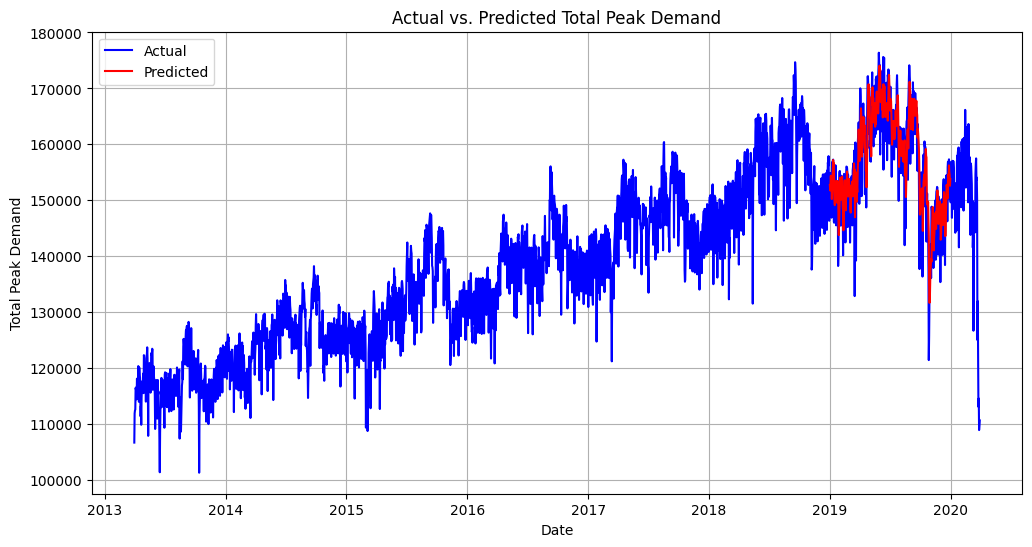

In [15]:
# plot the actual values and predicted values of test data using SARIMA

plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['Total_peak_demand'], label='Actual', color='blue')
plt.plot(test['date'], test_predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Total Peak Demand')
plt.title('Actual vs. Predicted Total Peak Demand')
plt.legend()
plt.grid(True)
plt.show()

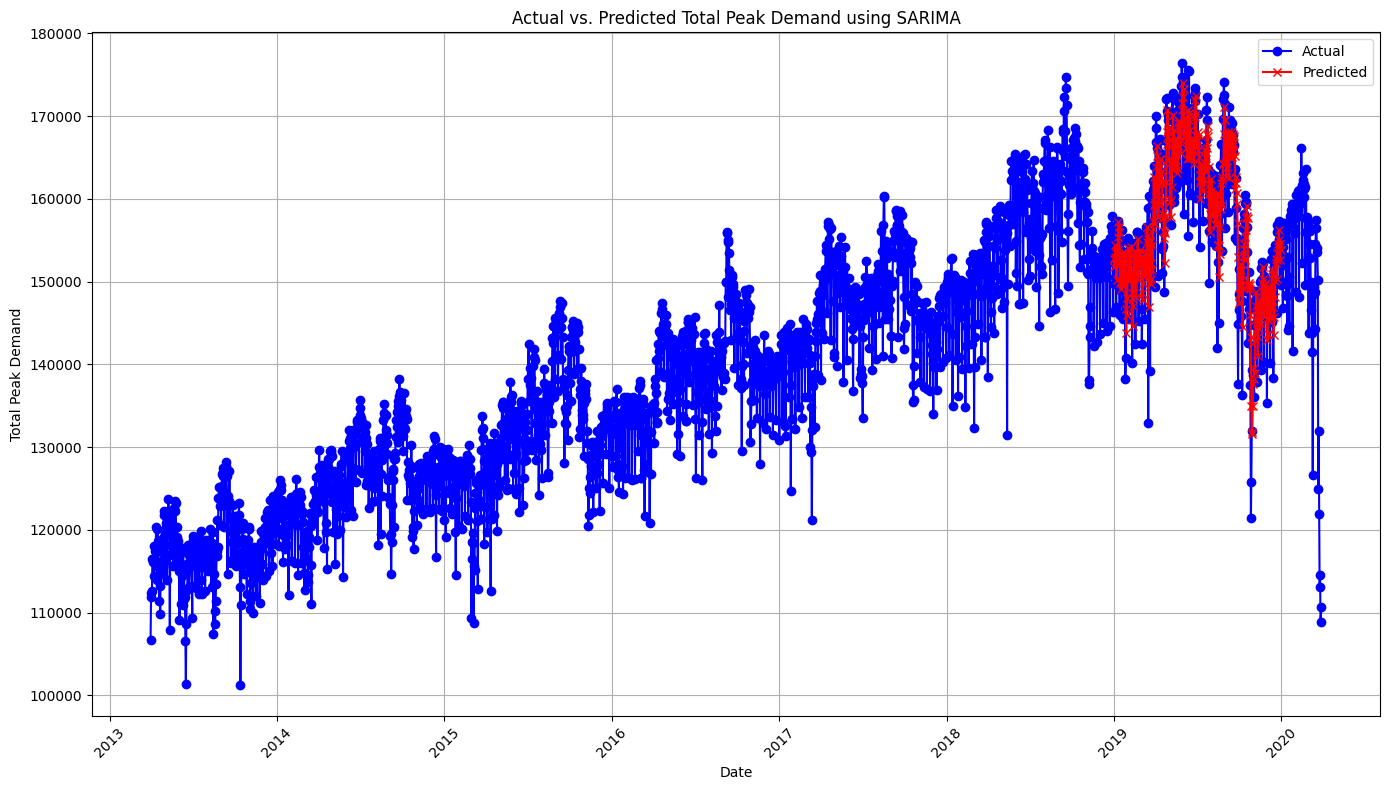

In [16]:
# increasing figure size and adding markers

plt.figure(figsize=(14, 8))
plt.plot(df['date'], df['Total_peak_demand'], label='Actual', color='blue', marker='o')
plt.plot(test['date'], test_predictions, label='Predicted', color='red', marker='x')

plt.xticks(rotation=45)

plt.xlabel('Date')
plt.ylabel('Total Peak Demand')
plt.title('Actual vs. Predicted Total Peak Demand using SARIMA')
plt.legend()
plt.grid(True)
plt.tight_layout()  
plt.show()

/var/folders/7y/d0fc_ry97zzfnvw4kc3xknyc0000gn/T/ipykernel_37050/3216744247.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['date'] = pd.to_datetime(test['date'])
/var/folders/7y/d0fc_ry97zzfnvw4kc3xknyc0000gn/T/ipykernel_37050/3216744247.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predicted'] = test_predictions


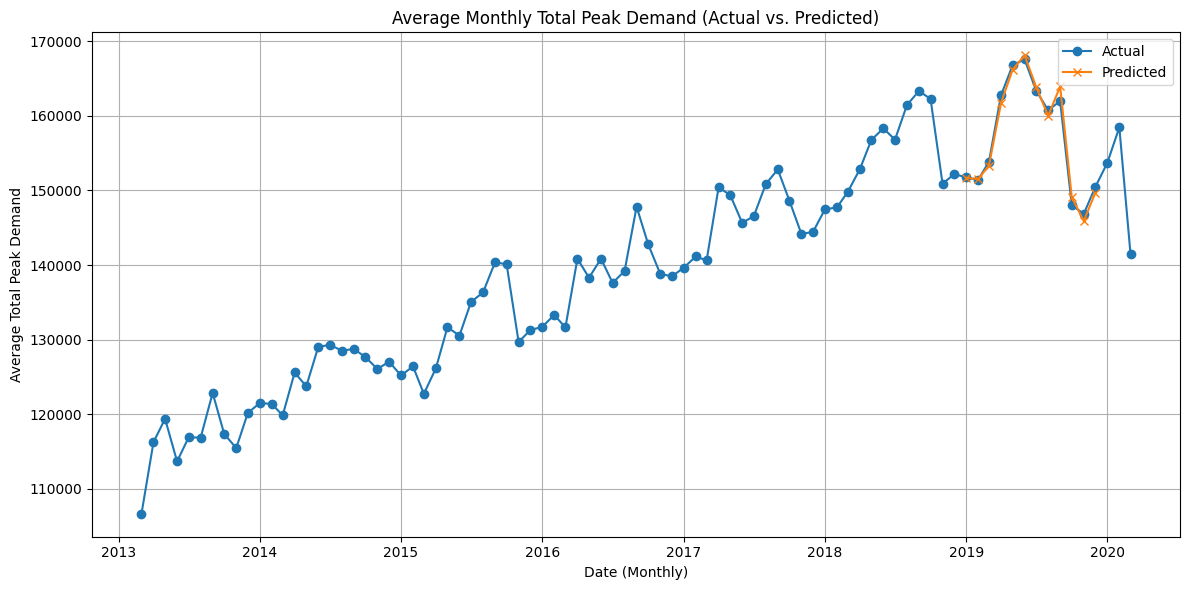

In [17]:
# plotting actual and predicted values on a monthly average basis

df['date'] = pd.to_datetime(df['date'])

# group the original data by month and calculate the average total peak demand for each month
orig_monthly_avg = df.groupby(df['date'].dt.to_period('M'))['Total_peak_demand'].mean()

# group the test predictions by month and calculate the average total peak demand for each month
test['date'] = pd.to_datetime(test['date'])  
test['Predicted'] = test_predictions
predicted_monthly_avg = test.groupby(test['date'].dt.to_period('M'))['Predicted'].mean()

plt.figure(figsize=(12, 6))
plt.plot(orig_monthly_avg.index.to_timestamp(), orig_monthly_avg.values, label='Actual', marker='o', linestyle='-')
plt.plot(predicted_monthly_avg.index.to_timestamp(), predicted_monthly_avg.values, label='Predicted', marker='x', linestyle='-')
plt.xlabel('Date (Monthly)')
plt.ylabel('Average Total Peak Demand')
plt.title('Average Monthly Total Peak Demand (Actual vs. Predicted)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

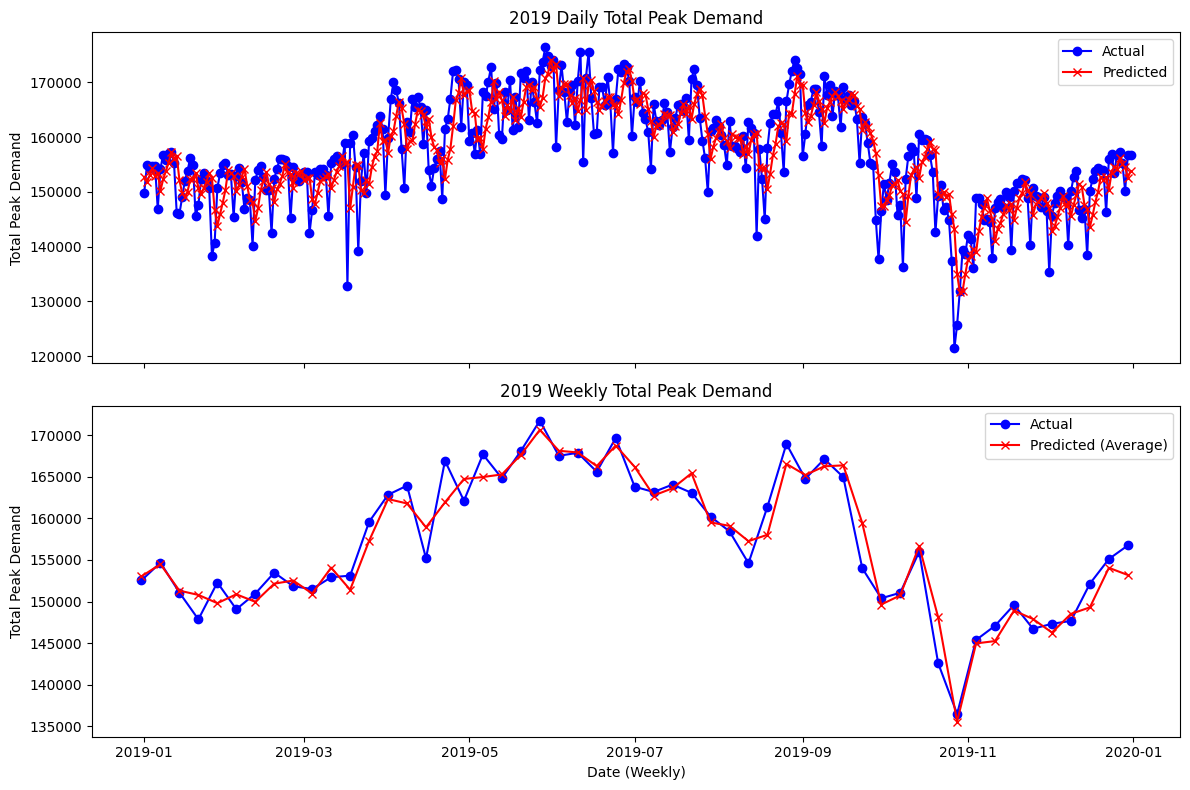

In [18]:
# creating subplots for day-wise and week-wise results for test data from 2019

# filter the data for the test year 2019
data_2019 = df[df['date'].dt.year == 2019]

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# subplot 1: daily results
axes[0].plot(data_2019['date'], data_2019['Total_peak_demand'], label='Actual', color='blue', marker='o')
axes[0].plot(test['date'], test_predictions, label='Predicted', color='red', marker='x')
axes[0].set_ylabel('Total Peak Demand')
axes[0].set_title('2019 Daily Total Peak Demand')
axes[0].legend()

# subplot 2: weekly results with averaged predictions
weekly_avg_actual = data_2019.groupby(data_2019['date'].dt.to_period('W'))['Total_peak_demand'].mean()
axes[1].plot(weekly_avg_actual.index.to_timestamp(), weekly_avg_actual.values, label='Actual', color='blue', marker='o')

weekly_avg_predicted = test.groupby(test['date'].dt.to_period('W'))['Predicted'].mean()
axes[1].plot(weekly_avg_predicted.index.to_timestamp(), weekly_avg_predicted.values, label='Predicted (Average)', color='red', marker='x')

axes[1].set_xlabel('Date (Weekly)')
axes[1].set_ylabel('Total Peak Demand')
axes[1].set_title('2019 Weekly Total Peak Demand')
axes[1].legend()

plt.tight_layout()
plt.show()

**PROPHET IMPLEMENTATION**

In [19]:
pr_train = train
pr_val = val
pr_test = test

In [20]:
# grid search to find the best (top 3) Prophet model parameters

top_3_results_pr_rmse, top_3_results_pr_mape = helper_forecast.find_best_prophet(pr_train, pr_val)

# print the top 3 results by RMSE
for i, (rmse, params) in enumerate(top_3_results_pr_rmse, start=1):
    print(f"Top {i} - RMSE: {rmse}, Parameters: {params}")

# print the top 3 results by MAPE
for i, (mape, params) in enumerate(top_3_results_pr_mape, start=1):
    print(f"Top {i} - MAPE: {mape}, Parameters: {params}")

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5365.47   1.46222e-05       5253.86           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       5365.48    7.0984e-07       4544.88   1.776e-10       0.001      163  LS failed, Hessian reset 
     141       5365.49   8.08286e-09       4694.97      0.3218           1      221   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5365.47   1.46222e-05       5253.86           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       5365.48    7.0984e-07       4544.88   1.776e-10       0.001      163  LS failed, Hessian reset 
     141       5365.49   8.08286e-09       4694.97      0.3218           1      221   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5365.47   1.46222e-05       5253.86           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       5365.48    7.0984e-07       4544.88   1.776e-10       0.001      163  LS failed, Hessian reset 
     141       5365.49   8.08286e-09       4694.97      0.3218           1      221   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5365.47   1.46222e-05       5253.86           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       5365.48    7.0984e-07       4544.88   1.776e-10       0.001      163  LS failed, Hessian reset 
     141       5365.49   8.08286e-09       4694.97      0.3218           1      221   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5370.29   6.03101e-07       427.747           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       5371.92   4.02661e-05       438.658   1.008e-07       0.001      286  LS failed, Hessian reset 
     199       5371.93    1.6245e-05        316.91           1           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       5371.93   1.29457e-06       442.691   3.185e-09       0.001      393  LS failed, Hessian reset 
     259       5371.93   2.23561e-08        380.03      0.2775      0.9417      419   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5370.29   6.03101e-07       427.747           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       5371.92   4.02661e-05       438.658   1.008e-07       0.001      286  LS failed, Hessian reset 
     199       5371.93    1.6245e-05        316.91           1           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       5371.93   1.29457e-06       442.691   3.185e-09       0.001      393  LS failed, Hessian reset 
     259       5371.93   2.23561e-08        380.03      0.2775      0.9417      419   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/

Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5370.29   6.03101e-07       427.747           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       5371.92   4.02661e-05       438.658   1.008e-07       0.001      286  LS failed, Hessian reset 
     199       5371.93    1.6245e-05        316.91           1           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       5371.93   1.29457e-06       442.691   3.185e-09       0.001      393  LS failed, Hessian reset 
     259       5371.93   2.23561e-08        380.03      0.2775      0.9417      419   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5370.29   6.03101e-07       427.747           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       5371.92   4.02661e-05       438.658   1.008e-07       0.001      286  LS failed, Hessian reset 
     199       5371.93    1.6245e-05        316.91           1           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       5371.93   1.29457e-06       442.691   3.185e-09       0.001      393  LS failed, Hessian reset 
     259       5371.93   2.23561e-08        380.03      0.2775      0.9417      419   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/

Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5421.47    0.00632382       1902.11      0.4863           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5442.71     0.0032568       152.872           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5460.53    0.00243898       484.914      0.2234           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5464.48   0.000344142       83.8925           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5467.36    0.00157559        114.34           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/

Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5421.47    0.00632382       1902.11      0.4863           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5442.71     0.0032568       152.872           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5460.53    0.00243898       484.914      0.2234           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5464.48   0.000344142       83.8925           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5467.36    0.00157559        114.34           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5421.47    0.00632382       1902.11      0.4863           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5442.71     0.0032568       152.872           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5460.53    0.00243898       484.914      0.2234           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5464.48   0.000344142       83.8925           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5467.36    0.00157559        114.34           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5421.47    0.00632382       1902.11      0.4863           1      112   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5442.71     0.0032568       152.872           1           1      225   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5460.53    0.00243898       484.914      0.2234           1      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5464.48   0.000344142       83.8925           1           1      443   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5467.36    0.00157559        114.34           1           1      560   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/

Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5442.91     0.0188623       577.985      0.7629      0.7629      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5483.05     0.0111815       1095.56           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5512.12    0.00543143       938.908      0.4579      0.4579      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5522.09   0.000606346       148.903      0.7364      0.7364      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5526.15   0.000865736       688.691      0.5795      0.5795      561   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5442.91     0.0188623       577.985      0.7629      0.7629      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5483.05     0.0111815       1095.56           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5512.12    0.00543143       938.908      0.4579      0.4579      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5522.09   0.000606346       148.903      0.7364      0.7364      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5526.15   0.000865736       688.691      0.5795      0.5795      561   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5442.91     0.0188623       577.985      0.7629      0.7629      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5483.05     0.0111815       1095.56           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5512.12    0.00543143       938.908      0.4579      0.4579      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5522.09   0.000606346       148.903      0.7364      0.7364      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5526.15   0.000865736       688.691      0.5795      0.5795      561   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5442.91     0.0188623       577.985      0.7629      0.7629      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5483.05     0.0111815       1095.56           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5512.12    0.00543143       938.908      0.4579      0.4579      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5522.09   0.000606346       148.903      0.7364      0.7364      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5526.15   0.000865736       688.691      0.5795      0.5795      561   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/

Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5670.89   0.000162126       4722.91           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       5676.55   4.92624e-05       4276.34    1.12e-08       0.001      229  LS failed, Hessian reset 
     199       5676.73   3.88156e-08       4288.14           1           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       5676.73   3.28844e-07       3959.62   6.424e-11       0.001      365  LS failed, Hessian reset 
     220       5676.73    3.8375e-09       3675.88       0.285       0.285      382   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5670.89   0.000162126       4722.91           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       5676.55   4.92624e-05       4276.34    1.12e-08       0.001      229  LS failed, Hessian reset 
     199       5676.73   3.88156e-08       4288.14           1           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       5676.73   3.28844e-07       3959.62   6.424e-11       0.001      365  LS failed, Hessian reset 
     220       5676.73    3.8375e-09       3675.88       0.285       0.285      382   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5670.89   0.000162126       4722.91           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       5676.55   4.92624e-05       4276.34    1.12e-08       0.001      229  LS failed, Hessian reset 
     199       5676.73   3.88156e-08       4288.14           1           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       5676.73   3.28844e-07       3959.62   6.424e-11       0.001      365  LS failed, Hessian reset 
     220       5676.73    3.8375e-09       3675.88       0.285       0.285      382   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/

Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5670.89   0.000162126       4722.91           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       5676.55   4.92624e-05       4276.34    1.12e-08       0.001      229  LS failed, Hessian reset 
     199       5676.73   3.88156e-08       4288.14           1           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       5676.73   3.28844e-07       3959.62   6.424e-11       0.001      365  LS failed, Hessian reset 
     220       5676.73    3.8375e-09       3675.88       0.285       0.285      382   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5691.59    0.00011439       403.112      0.2292           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       5691.62   3.35469e-08       387.551      0.4012      0.4012      187   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5691.59    0.00011439       403.112      0.2292           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       5691.62   3.35469e-08       387.551      0.4012      0.4012      187   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5691.59    0.00011439       403.112      0.2292           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       5691.62   3.35469e-08       387.551      0.4012      0.4012      187   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5691.59    0.00011439       403.112      0.2292           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       5691.62   3.35469e-08       387.551      0.4012      0.4012      187   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5734.8    0.00995876       834.913           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5747.46    0.00104851       530.575      0.8633      0.8633      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5760.41   0.000386553       73.9451           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5762.93    0.00394194       444.333           1           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     452       5763.65   7.23408e-05        215.88   9.714e-07       0.001      577  LS failed, Hessian reset 
     499       5764.22   0.000521687    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5734.8    0.00995876       834.913           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5747.46    0.00104851       530.575      0.8633      0.8633      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5760.41   0.000386553       73.9451           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5762.93    0.00394194       444.333           1           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     452       5763.65   7.23408e-05        215.88   9.714e-07       0.001      577  LS failed, Hessian reset 
     499       5764.22   0.000521687    

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5734.8    0.00995876       834.913           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5747.46    0.00104851       530.575      0.8633      0.8633      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5760.41   0.000386553       73.9451           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5762.93    0.00394194       444.333           1           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     452       5763.65   7.23408e-05        215.88   9.714e-07       0.001      577  LS failed, Hessian reset 
     499       5764.22   0.000521687    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5734.8    0.00995876       834.913           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5747.46    0.00104851       530.575      0.8633      0.8633      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5760.41   0.000386553       73.9451           1           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5762.93    0.00394194       444.333           1           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     452       5763.65   7.23408e-05        215.88   9.714e-07       0.001      577  LS failed, Hessian reset 
     499       5764.22   0.000521687    

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/

Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5748.98    0.00688153       603.126      0.9917      0.9917      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5777.28     0.0122029       765.528      0.4019           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        5802.9     0.0180748       1224.19           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        5819.5    0.00163404       315.632           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        5825.3    0.00899331       590.727           1           1      571   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5748.98    0.00688153       603.126      0.9917      0.9917      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5777.28     0.0122029       765.528      0.4019           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        5802.9     0.0180748       1224.19           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        5819.5    0.00163404       315.632           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        5825.3    0.00899331       590.727           1           1      571   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5748.98    0.00688153       603.126      0.9917      0.9917      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5777.28     0.0122029       765.528      0.4019           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        5802.9     0.0180748       1224.19           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        5819.5    0.00163404       315.632           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        5825.3    0.00899331       590.727           1           1      571   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5748.98    0.00688153       603.126      0.9917      0.9917      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5777.28     0.0122029       765.528      0.4019           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        5802.9     0.0180748       1224.19           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        5819.5    0.00163404       315.632           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        5825.3    0.00899331       590.727           1           1      571   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5679.7   6.06199e-05       5450.57       0.238       0.238      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       5682.16   5.18045e-07       4423.44   1.064e-10       0.001      270  LS failed, Hessian reset 
     188       5682.16   9.69516e-09       3834.28      0.1894      0.1894      285   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5679.7   6.06199e-05       5450.57       0.238       0.238      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       5682.16   5.18045e-07       4423.44   1.064e-10       0.001      270  LS failed, Hessian reset 
     188       5682.16   9.69516e-09       3834.28      0.1894      0.1894      285   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5679.7   6.06199e-05       5450.57       0.238       0.238      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       5682.16   5.18045e-07       4423.44   1.064e-10       0.001      270  LS failed, Hessian reset 
     188       5682.16   9.69516e-09       3834.28      0.1894      0.1894      285   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5679.7   6.06199e-05       5450.57       0.238       0.238      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       5682.16   5.18045e-07       4423.44   1.064e-10       0.001      270  LS failed, Hessian reset 
     188       5682.16   9.69516e-09       3834.28      0.1894      0.1894      285   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Error evaluating model log probability: Non-finite gradient.

      99       5695.79   0.000482776       524.141      0.9068      0.9068      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       5696.62   0.000123233       707.353   2.085e-07       0.001      231  LS failed, Hessian reset 
     199       5696.98   5.40779e-06       373.585           1           1      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5697.15   3.91515e-07       377.878      0.4609      0.4609      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     390       5697.29   1.47344e-05       421.941   3.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/

Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Error evaluating model log probability: Non-finite gradient.

      99       5695.79   0.000482776       524.141      0.9068      0.9068      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       5696.62   0.000123233       707.353   2.085e-07       0.001      231  LS failed, Hessian reset 
     199       5696.98   5.40779e-06       373.585           1           1      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5697.15   3.91515e-07       377.878      0.4609      0.4609      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     390       5697.29   1.47344e-05       421.941   3.

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Error evaluating model log probability: Non-finite gradient.

      99       5695.79   0.000482776       524.141      0.9068      0.9068      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       5696.62   0.000123233       707.353   2.085e-07       0.001      231  LS failed, Hessian reset 
     199       5696.98   5.40779e-06       373.585           1           1      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5697.15   3.91515e-07       377.878      0.4609      0.4609      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     390       5697.29   1.47344e-05       421.941   3.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Error evaluating model log probability: Non-finite gradient.

      99       5695.79   0.000482776       524.141      0.9068      0.9068      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       5696.62   0.000123233       707.353   2.085e-07       0.001      231  LS failed, Hessian reset 
     199       5696.98   5.40779e-06       373.585           1           1      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5697.15   3.91515e-07       377.878      0.4609      0.4609      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     390       5697.29   1.47344e-05       421.941   3.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/

Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5739.79   0.000648344         580.7      0.2777      0.2777      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5757.95     0.0385668       1073.35           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5767.15    0.00279033       120.872           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399          5769    0.00805947        346.62           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        5771.4   0.000503729       129.656      0.2972      0.2972      583   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5739.79   0.000648344         580.7      0.2777      0.2777      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5757.95     0.0385668       1073.35           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5767.15    0.00279033       120.872           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399          5769    0.00805947        346.62           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        5771.4   0.000503729       129.656      0.2972      0.2972      583   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5739.79   0.000648344         580.7      0.2777      0.2777      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5757.95     0.0385668       1073.35           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5767.15    0.00279033       120.872           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399          5769    0.00805947        346.62           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        5771.4   0.000503729       129.656      0.2972      0.2972      583   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/

Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5739.79   0.000648344         580.7      0.2777      0.2777      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5757.95     0.0385668       1073.35           1           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5767.15    0.00279033       120.872           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399          5769    0.00805947        346.62           1           1      462   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        5771.4   0.000503729       129.656      0.2972      0.2972      583   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5754.44     0.0070143       687.993           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5784.66    0.00170049       449.892           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5806.94    0.00101012       367.514           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5811.42    0.00065028         189.8           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          5833     0.0212869       1347.56      0.5055      0.5055      570   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/

Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5754.44     0.0070143       687.993           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5784.66    0.00170049       449.892           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5806.94    0.00101012       367.514           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5811.42    0.00065028         189.8           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          5833     0.0212869       1347.56      0.5055      0.5055      570   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5754.44     0.0070143       687.993           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5784.66    0.00170049       449.892           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5806.94    0.00101012       367.514           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5811.42    0.00065028         189.8           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          5833     0.0212869       1347.56      0.5055      0.5055      570   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5754.44     0.0070143       687.993           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5784.66    0.00170049       449.892           1           1      231   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5806.94    0.00101012       367.514           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5811.42    0.00065028         189.8           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499          5833     0.0212869       1347.56      0.5055      0.5055      570   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/

Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5682.42   9.01837e-05       4297.41      0.2971           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       5682.64   6.52634e-09       3967.72      0.2607      0.2607      175   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5682.42   9.01837e-05       4297.41      0.2971           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       5682.64   6.52634e-09       3967.72      0.2607      0.2607      175   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5682.42   9.01837e-05       4297.41      0.2971           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       5682.64   6.52634e-09       3967.72      0.2607      0.2607      175   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5682.42   9.01837e-05       4297.41      0.2971           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       5682.64   6.52634e-09       3967.72      0.2607      0.2607      175   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Error evaluating model log probability: Non-finite gradient.

      99       5696.61   0.000293259       692.132      0.4907      0.4907      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127          5697   0.000278493       558.191   6.326e-07       0.001      217  LS failed, Hessian reset 
     165       5697.11   7.05858e-08       388.146           1           1      268   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Error evaluating model log probability: Non-finite gradient.

      99       5696.61   0.000293259       692.132      0.4907      0.4907      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127          5697   0.000278493       558.191   6.326e-07       0.001      217  LS failed, Hessian reset 
     165       5697.11   7.05858e-08       388.146           1           1      268   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Error evaluating model log probability: Non-finite gradient.

      99       5696.61   0.000293259       692.132      0.4907      0.4907      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127          5697   0.000278493       558.191   6.326e-07       0.001      217  LS failed, Hessian reset 
     165       5697.11   7.05858e-08       388.146           1           1      268   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Exception: normal_lpdf: Scale parameter is 0, but must be > 0!  (in 'unknown file name' at line 136)

Error evaluating model log probability: Non-finite gradient.

      99       5696.61   0.000293259       692.132      0.4907      0.4907      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127          5697   0.000278493       558.191   6.326e-07       0.001      217  LS failed, Hessian reset 
     165       5697.11   7.05858e-08       388.146           1           1      268   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/

Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5735.48    0.00268197       615.651           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5760.12    0.00205184        199.41      0.9464      0.9464      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5766.36    0.00250798       103.573       1.606      0.1606      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5768.94   0.000446291       138.386      0.5516      0.5516      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5770.44   0.000402071        55.046           1           1      583   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5735.48    0.00268197       615.651           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5760.12    0.00205184        199.41      0.9464      0.9464      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5766.36    0.00250798       103.573       1.606      0.1606      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5768.94   0.000446291       138.386      0.5516      0.5516      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5770.44   0.000402071        55.046           1           1      583   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5735.48    0.00268197       615.651           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5760.12    0.00205184        199.41      0.9464      0.9464      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5766.36    0.00250798       103.573       1.606      0.1606      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5768.94   0.000446291       138.386      0.5516      0.5516      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5770.44   0.000402071        55.046           1           1      583   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5735.48    0.00268197       615.651           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5760.12    0.00205184        199.41      0.9464      0.9464      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5766.36    0.00250798       103.573       1.606      0.1606      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5768.94   0.000446291       138.386      0.5516      0.5516      465   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5770.44   0.000402071        55.046           1           1      583   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5758.76     0.0103622       707.586           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5796.01     0.0132051       1264.31           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5818.46    0.00284982       330.917           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5825.72    0.00456928        696.88           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5846.67     0.0506361       1725.12           1           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/

Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5758.76     0.0103622       707.586           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5796.01     0.0132051       1264.31           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5818.46    0.00284982       330.917           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5825.72    0.00456928        696.88           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5846.67     0.0506361       1725.12           1           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5758.76     0.0103622       707.586           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5796.01     0.0132051       1264.31           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5818.46    0.00284982       330.917           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5825.72    0.00456928        696.88           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5846.67     0.0506361       1725.12           1           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/

Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5758.76     0.0103622       707.586           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       5796.01     0.0132051       1264.31           1           1      230   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       5818.46    0.00284982       330.917           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       5825.72    0.00456928        696.88           1           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       5846.67     0.0506361       1725.12           1           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha  

In [31]:
# print the top 3 results by RMSE
for i, (rmse, params) in enumerate(top_3_results_pr_rmse, start=1):
    print(f"Top {i} - RMSE: {rmse}, Parameters: {params}")

# print the top 3 results by MAPE
for i, (mape, params) in enumerate(top_3_results_pr_mape, start=1):
    print(f"Top {i} - MAPE: {mape}, Parameters: {params}")

Top 1 - RMSE: 5063.797381676226, Parameters: (0.1, 0.001, 0.001)
Top 2 - RMSE: 5063.797381676226, Parameters: (0.1, 0.001, 0.01)
Top 3 - RMSE: 5063.797381676226, Parameters: (0.1, 0.001, 0.1)
Top 1 - MAPE: 2.5506624741823756, Parameters: (0.1, 0.001, 0.001)
Top 2 - MAPE: 2.5506624741823756, Parameters: (0.1, 0.001, 0.01)
Top 3 - MAPE: 2.5506624741823756, Parameters: (0.1, 0.001, 0.1)


In [21]:
# fit the Prophet model with the best hyperparameters for Prophet

# define the hyperparameters based on the top result
seasonality_prior_scale, changepoint_prior_scale, holidays_prior_scale = top_3_results_pr_rmse[0][1]

model = Prophet(
    seasonality_prior_scale=seasonality_prior_scale,
    changepoint_prior_scale=changepoint_prior_scale,
    holidays_prior_scale=holidays_prior_scale
)
model.fit(pr_train.rename(columns={'date': 'ds', 'Total_peak_demand': 'y'}))

# make predictions on the test data
future_test = pd.DataFrame(pr_test['date'].values, columns=['ds'])
forecast = model.predict(future_test)

predicted_values = forecast['yhat'].values

# calculate RMSE
rmse = helper_forecast.rmse(pr_test['Total_peak_demand'], predicted_values)
print(f"Prophet Test Data RMSE: {rmse}")

# calculate MAPE
mape = helper_forecast.mape(pr_test['Total_peak_demand'], predicted_values)
print(f"Prophet Test Data MAPE: {mape}")


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -5.67865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        5679.7   6.06199e-05       5450.57       0.238       0.238      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       5682.16   5.18045e-07       4423.44   1.064e-10       0.001      270  LS failed, Hessian reset 
     188       5682.16   9.69516e-09       3834.28      0.1894      0.1894      285   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Prophet Test Data RMSE: 9313.365228728611
Prophet Test Data MAPE: 4.652768798850767


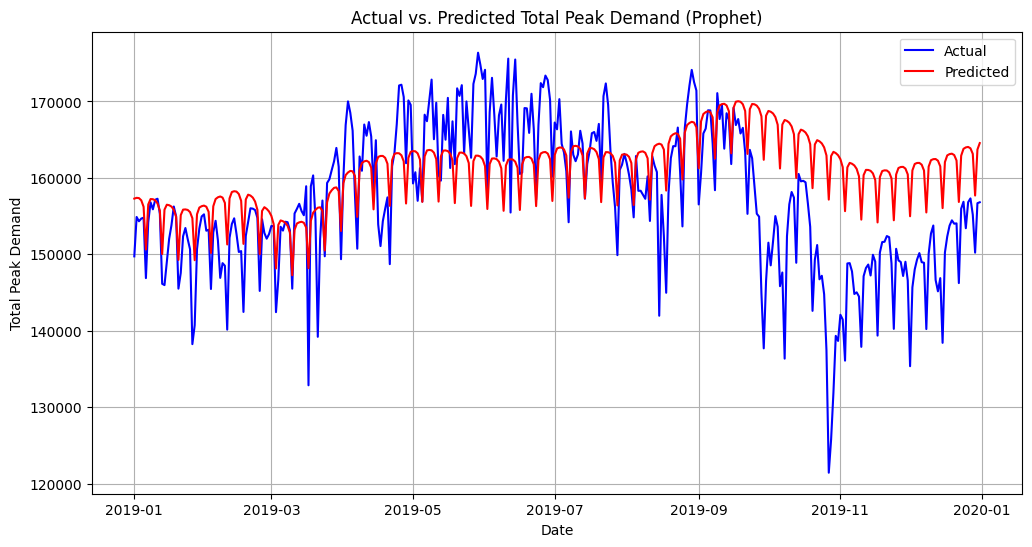

In [22]:
# plot actual vs. predicted values based on Prophet

plt.figure(figsize=(12, 6))
plt.plot(pr_test['date'], pr_test['Total_peak_demand'], label='Actual', color='blue')
plt.plot(pr_test['date'], predicted_values, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Total Peak Demand')
plt.title('Actual vs. Predicted Total Peak Demand (Prophet)')
plt.legend()
plt.grid(True)
plt.show()

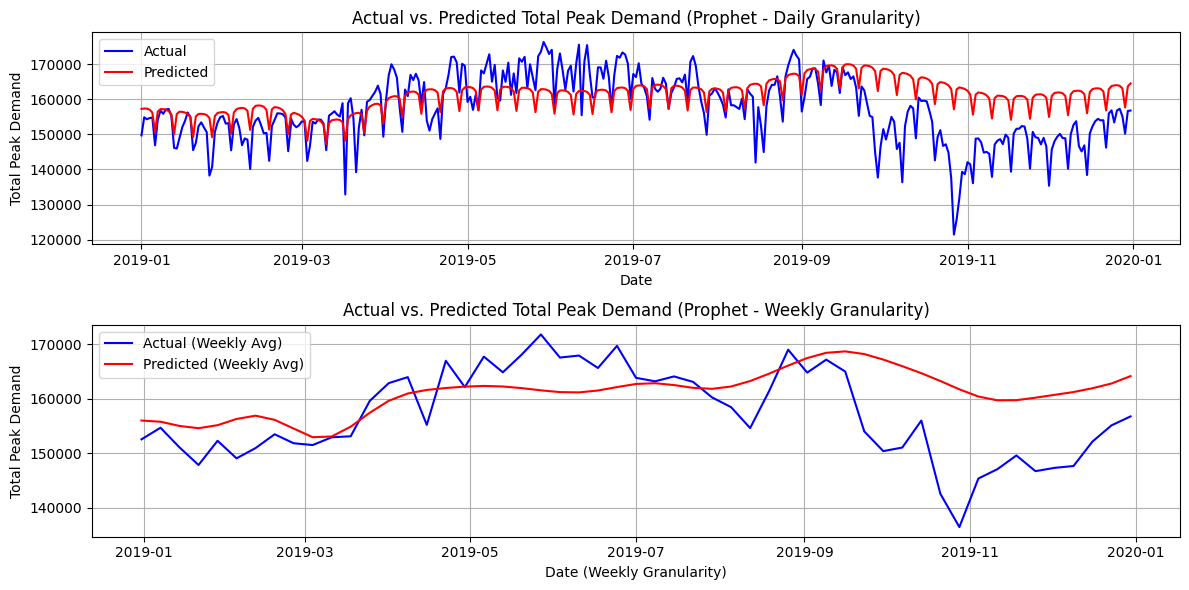

In [23]:
# daily granularity plots for Prophet predictions

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(pr_test['date'], pr_test['Total_peak_demand'], label='Actual', color='blue')
plt.plot(pr_test['date'], predicted_values, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Total Peak Demand')
plt.title('Actual vs. Predicted Total Peak Demand (Prophet - Daily Granularity)')
plt.legend()
plt.grid(True)

# weekly daily granularity plots for Prophet predictions
weekly_avg_actual = pr_test.groupby(pr_test['date'].dt.to_period('W'))['Total_peak_demand'].mean()
weekly_avg_predicted = forecast.groupby(forecast['ds'].dt.to_period('W'))['yhat'].mean()

plt.subplot(2, 1, 2)
plt.plot(weekly_avg_actual.index.to_timestamp(), weekly_avg_actual.values, label='Actual (Weekly Avg)', color='blue')
plt.plot(weekly_avg_predicted.index.to_timestamp(), weekly_avg_predicted.values, label='Predicted (Weekly Avg)', color='red')
plt.xlabel('Date (Weekly Granularity)')
plt.ylabel('Total Peak Demand')
plt.title('Actual vs. Predicted Total Peak Demand (Prophet - Weekly Granularity)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**LSTM IMPLEMENTATION**

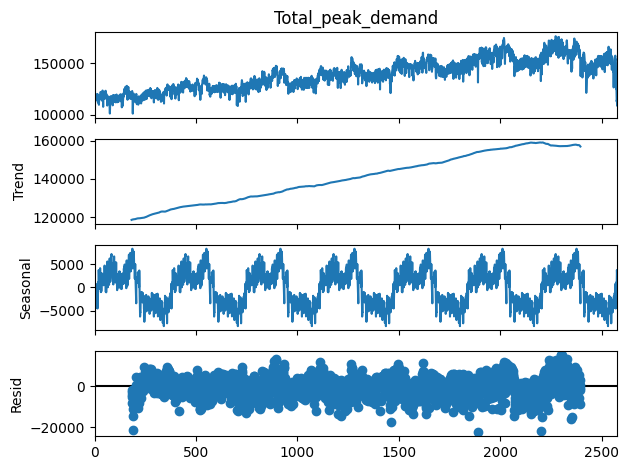

,date,NR_peak_demand,WR_peak_demand,SR_peak_demand,ER_peak_demand,NER_peak_demand,Total_peak_demand,NR_peak_shortage,WR_peak_shortage,SR_peak_shortage,ER_peak_shortage,NER_peak_shortage,Total_peak_shortage,year,month,day,seasonal_adj_demand
0,2013-03-31,27482,34592,28778,14256.0,1557,106665.0,1500,889,5156,416,355,8316,2013,3,31,0.000000
1,2013-04-01,28291,36791,30828,14308.0,1659,111877.0,1694,1073,5663,857,249,9536,2013,4,1,4666.942922
2,2013-04-02,29845,36496,30407,14061.0,1594,112403.0,2010,969,5792,601,331,9703,2013,4,2,-1264.470320
3,2013-04-03,31321,37155,28887,13563.0,1660,112586.0,2108,793,6514,1142,307,10864,2013,4,3,713.054338
4,2013-04-04,32182,37303,30916,14520.0,1537,116458.0,2036,1167,5409,1013,383,10008,2013,4,4,2774.898174


In [24]:
import statsmodels.api as sm

result = sm.tsa.seasonal_decompose(df['Total_peak_demand'], model='additive', period = 365)
result.plot()
plt.show()

# seasonal adjustment
df['seasonal_adj_demand'] = df['Total_peak_demand'] - result.seasonal

# differencing data
df['seasonal_adj_demand'] = df['seasonal_adj_demand'].diff().dropna()
df = df.fillna(0)
df.head()

In [25]:
# create training, validation and test data sets

lstm_train = df.loc[df['year'].between(2013, 2017), ['seasonal_adj_demand', 'date']]
lstm_val = df.loc[df['year'] == 2018, ['seasonal_adj_demand', 'date']]
lstm_test =  df.loc[df['year'] == 2019, ['seasonal_adj_demand', 'date']]

In [26]:
# grid search to find the best (top 3) LSTM model parameters

top_3_results_lstm_rmse, top_3_results_lstm_mape = helper_forecast.find_best_LSTM(lstm_train, lstm_val)


12/12 [==============================] - 0s 914us/step


In [27]:
# print the top 3 results by RMSE
for i, (rmse, params) in enumerate(top_3_results_lstm_rmse):
    print(f"Top {i} - RMSE: {rmse}, Parameters: {params}")

# print the top 3 results by MAPE
for i, (mape, params) in enumerate(top_3_results_lstm_mape):
    print(f"Top {i} - MAPE: {mape}, Parameters: {params}")

Top 0 - RMSE: 4499.258342323839, Parameters: (64, 32, 0.001)
Top 1 - RMSE: 4518.160579830859, Parameters: (256, 128, 0.001)
Top 2 - RMSE: 4628.370667815102, Parameters: (256, 128, 0.01)
Top 0 - MAPE: 1635327.2301867178, Parameters: (256, 128, 0.01)
Top 1 - MAPE: 1710415.5679142529, Parameters: (128, 32, 0.01)
Top 2 - MAPE: 1720199.4727292298, Parameters: (64, 32, 0.1)


In [28]:
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler


# Define the selected hyperparameters
lstm_units, batch_size, learning_rate = top_3_results_lstm_rmse[0][1]


# build and compile the LSTM model with the selected best parameters
model = Sequential()
model.add(LSTM(units=lstm_units, input_shape=(lstm_train.shape[1], 1)))
model.add(Dropout(0.2)) 
model.add(Dense(1))
optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)
model.compile(loss='mean_squared_error', optimizer=optimizer)

# define early stopping to prevent overfitting
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# extract y_train, y_val and y_test from the respective datasets
y_train = lstm_train['seasonal_adj_demand'].values.reshape(-1,1)
y_val = lstm_val['seasonal_adj_demand'].values.reshape(-1,1)
y_test = lstm_test['seasonal_adj_demand'].values.reshape(-1,1)


scaler = MinMaxScaler()
train_demand_scaled = scaler.fit_transform(y_train)
val_demand_scaled = scaler.transform(y_val)
test_demand_scaled = scaler.transform(y_test)


# fit the model on the training data
history = model.fit(
    lstm_train.drop(columns=['date']).values, train_demand_scaled,  
    batch_size=batch_size,
    epochs=100,
    validation_data=(lstm_val.drop(columns=['date']).values, val_demand_scaled), 
    callbacks=[early_stopping],
    verbose=0
)

# extract X_test from lstm_test
X_test = lstm_test.drop(columns=['date']).values

# make predictions on the test data
test_predictions = model.predict(X_test)

test_predictions = scaler.inverse_transform(test_predictions)

# calculate RMSE on the test set
test_rmse = helper_forecast.rmse(y_test, test_predictions)
print(f"LSTM Test Data RMSE: {test_rmse}")

# calculate MAPE on the test set
test_mape = helper_forecast.mape(y_test, test_predictions)
print(f"LSTM Test Data MAPE: {test_mape}")

12/12 [==============================] - 0s 646us/step
LSTM Test Data RMSE: 3358.7556120356603
LSTM Test Data MAPE: 93.32896770944018


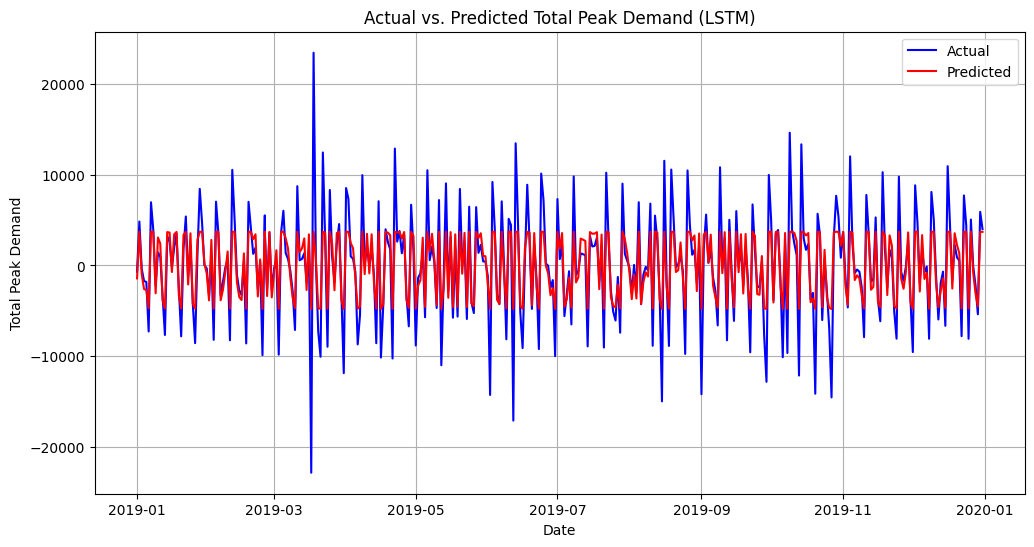

In [29]:
# plot actual vs. predicted values based on LSTM

plt.figure(figsize=(12, 6))
plt.plot(lstm_test['date'], y_test, label='Actual', color='blue')
plt.plot(lstm_test['date'], test_predictions, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Total Peak Demand')
plt.title('Actual vs. Predicted Total Peak Demand (LSTM)')
plt.legend()
plt.grid(True)
plt.show()

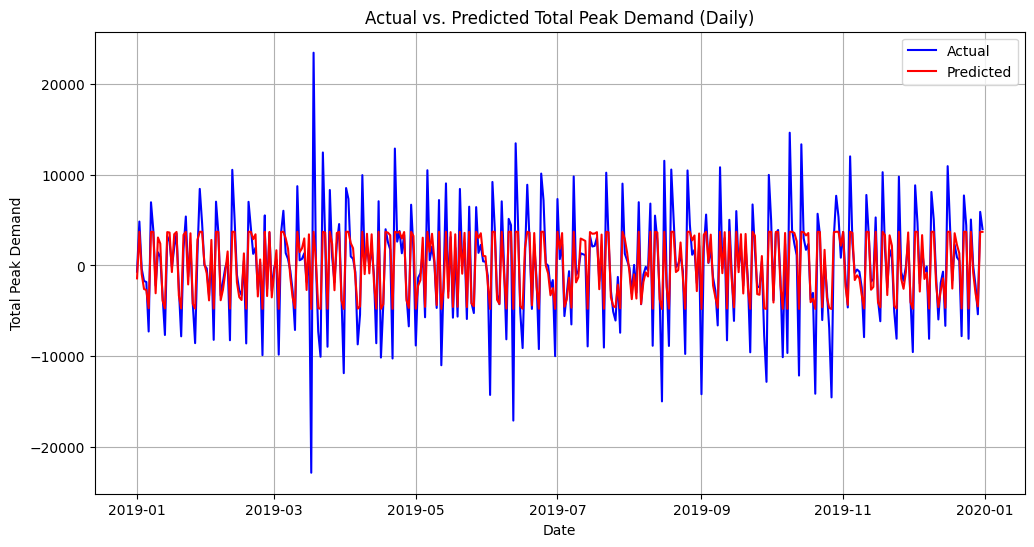

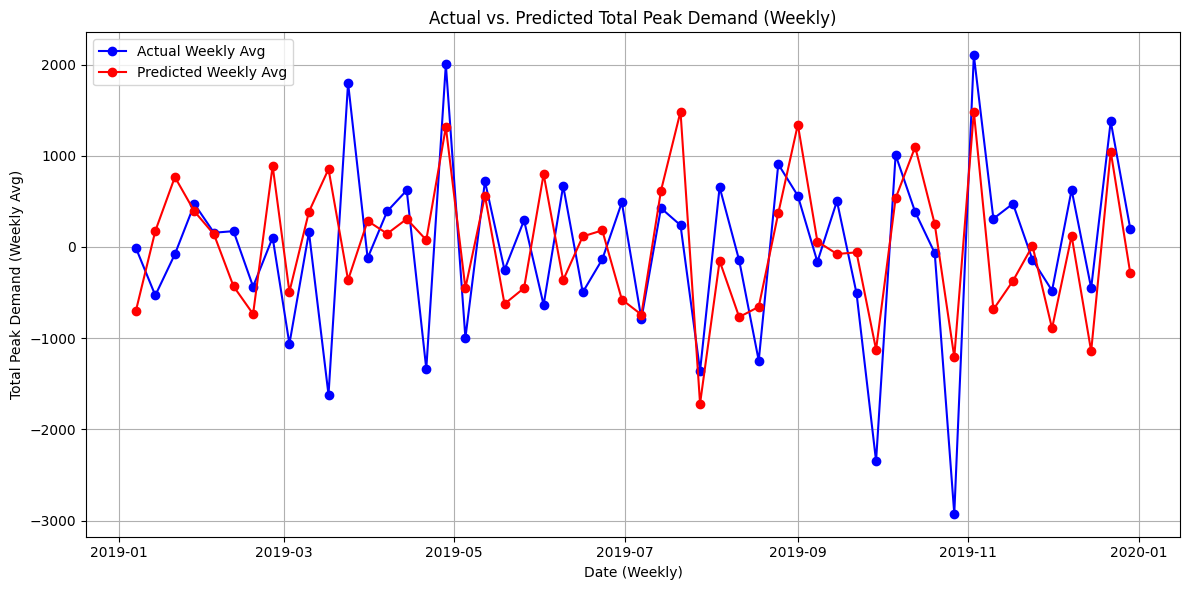

In [30]:
# ploting daily and weekly granular predictions 

dates = lstm_test['date']
actual_values = y_test
predicted_values = test_predictions.flatten()

# actual vs. predicted daily values 
plt.figure(figsize=(12, 6))
plt.plot(dates, actual_values, label='Actual', color='blue')
plt.plot(dates, predicted_values, label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Total Peak Demand')
plt.title('Actual vs. Predicted Total Peak Demand (Daily)')
plt.legend()
plt.grid(True)


weekly_dates = []
weekly_actual_averages = []
weekly_predicted_averages = []

window_size = 7  # 7 days in a week
for i in range(0, len(dates) - window_size + 1, window_size):
    weekly_dates.append(dates.iloc[i + window_size - 1])  
    weekly_actual_averages.append(np.mean(actual_values[i:i + window_size]))
    weekly_predicted_averages.append(np.mean(predicted_values[i:i + window_size]))

# weekly averages of actual vs. predicted values
plt.figure(figsize=(12, 6))
plt.plot(weekly_dates, weekly_actual_averages, label='Actual Weekly Avg', color='blue', marker='o')
plt.plot(weekly_dates, weekly_predicted_averages, label='Predicted Weekly Avg', color='red', marker='o')
plt.xlabel('Date (Weekly)')
plt.ylabel('Total Peak Demand (Weekly Avg)')
plt.title('Actual vs. Predicted Total Peak Demand (Weekly)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()